In [1]:
import argparse
import pandas as pd
""

BASE_DIR = "../gem5/benchmarks/results/" # change to your dir



In [2]:
def convert_str_to_num(s):
    """Convert string to either float or int"""
    try:
        return int(s)
    except ValueError:
        return float(s)



    

    

In [3]:
# single core
metrics_wanted = ["overallMissRate::total", "bwTotal::total",
                  "ipc"]


In [4]:

def get_metrics(lines):
    metrics = {}
    for line in lines:
        line_lowercase = line.lower()
        
  
        if "miss" in line_lowercase or "hit" in line_lowercase or "system.l3" in line_lowercase or "ipc" in line_lowercase:
            # the line is interesting to us. extract the first and second non-whitespace words
            words = line.split()
            metric = words[0]
            value = words[1]
            if metric not in metrics:
                metrics[metric] = convert_str_to_num(words[1])

    rows = []
    for k,v in metrics.items():
        rows.append([k,v])

    metrics_df = pd.DataFrame(rows, columns=["metric", "value"])
    return metrics_df


In [5]:


def over_threshold(percent, threshold):
    # return True if the percent difference between a and b is greater than the threshold
    # ensure that the first number is greater than the second
    return abs(percent) > threshold



In [6]:

def get_percent_diff(a, b):
    # return the percent difference between a and b
    # ensure that the first number is greater than the second
    if a < b:
        a, b = b, a
    try:
        percent_diff = (a - b) / a
        return percent_diff
    except ZeroDivisionError:
        return 0


In [7]:


def get_file_lines(file):
    with open(file, "r") as f:
        lines = f.readlines()
    return lines

    


In [8]:

def get_same_metrics_singlecore(df):
    # metrics are in the order 
    # system.cpu.<metric we are interested in>
    # we want to get the metrics that are the same for all cores
    # so we can compare them
    # we will assume that the first core is the same as the rest
    

    

    # convert to a dict
    rows=[]
    for idx, row in df.iterrows():
        value = row.value
        if row.metric.startswith("system.cpu"):
            metric = row.metric.replace("system.cpu.", "")
            rows.append([metric, value])
        elif row.metric.startswith("system.l3"):
            metric = row.metric.replace("system.l3", "l3")
            rows.append([metric, value])

    # make a dataframe
    first_core = pd.DataFrame(rows, columns=["metric", "value"])
    return first_core




In [9]:

# file1 = parser.add_argument("--file1", help="File 1", required=True)
# file4 = parser.add_argument("--file4", help="File 4", required=True)

riscv_file1 = BASE_DIR + "RISC-V/FFT/1_core/Base16Delta8/stats.txt"
riscv_file4 = BASE_DIR + "RISC-V/FFT/4_core/Base16Delta8/stats.txt"

x86_file1 = BASE_DIR + "X86/FFT/1_core/Base16Delta8/stats.txt"
x86_file4 = BASE_DIR + "X86/FFT/4_core/Base16Delta8/stats.txt"

riscv_file1_lines = get_file_lines(riscv_file1)
riscv_file4_lines = get_file_lines(riscv_file4)

x86_file1_lines = get_file_lines(x86_file1)
x86_file4_lines = get_file_lines(x86_file4)

riscv_file1_metrics = get_metrics(riscv_file1_lines)
riscv_file4_metrics = get_metrics(riscv_file4_lines)

x86_file1_metrics = get_metrics(x86_file1_lines)
x86_file4_metrics = get_metrics(x86_file4_lines)

# file1_metrics

riscv_cpu1core = get_same_metrics_singlecore(riscv_file1_metrics)
print(riscv_cpu1core)
# get the data frame from file1 and file4

x86_cpu1core = get_same_metrics_singlecore(x86_file1_metrics)
print(x86_cpu1core)


                                                metric         value
0                               numIssuedDist::samples  2.740277e+07
1                                  numIssuedDist::mean  1.623901e+00
2                                 numIssuedDist::stdev  2.065006e+00
3                            numIssuedDist::underflows  0.000000e+00
4                                     numIssuedDist::0  1.312692e+07
..                                                 ...           ...
576                               l3.tags.dataAccesses  9.463441e+06
577                    l3.tags.evictionsReplacement::0  5.040100e+04
578                    l3.tags.evictionsReplacement::1  0.000000e+00
579                    l3.tags.evictionsReplacement::2  0.000000e+00
580  l3.tags.power_state.pwrStateResidencyTicks::UN...  9.151769e+09

[581 rows x 2 columns]
                                                metric         value
0                               numIssuedDist::samples  3.258326e+07
1         

In [10]:
def get_same_metrics_multicore(df, num_cores, avg=False):
    # metrics are in the order 
    # system.cpu[num for cpu core].<metric we are interested in>
    # we want to get the metrics that are the same for all cores
    # so we can compare them
    # we will assume that the first core is the same as the rest
    

    cores = [f"system.cpu{i}." for i in range(num_cores)]
    # get the first core
    core_metric_rows = {}
    for core in cores:
        for idx, row in df.iterrows():
            value = row.value
            if row.metric.startswith(core):
                metric = row.metric.replace(core, "")
                if metric not in core_metric_rows:
                    core_metric_rows[metric] = value
                else:
  
                    core_metric_rows[metric] += value

    rows = []
    for k,v in core_metric_rows.items():
        if avg:
            core_metric_rows[k] = v / num_cores
        rows.append([k, core_metric_rows[k]])

    
    # L3
    for idx, row in df.iterrows():
        value = row.value
        if row.metric.startswith("system.l3"):
            metric = row.metric.replace("system.l3", "l3")
            rows.append([metric, value])

    # make a dataframe
    cores_df = pd.DataFrame(rows, columns=["metric", "value"])
    return cores_df
        

                
# get_same_metrics_multicore(file4_metrics, 4, avg=True)


In [11]:
# cpu4core = get_same_metrics_multicore(file4_metrics, 4, avg=True)
# cpu4core



In [12]:
def find_metric(metric, df):
    # find the metric in the dataframe
    # return the value
    results = []

    for idx, row in df.iterrows():
        if metric in row.metric:

            results.append({
               row.metric: row.value
            })
            # return row.value
    return results

In [13]:
# single core
metrics_wanted = ["overallMissRate::total", "ipc"]

In [14]:
for metric in metrics_wanted:
    print(find_metric(metric, riscv_cpu1core))

[{'dcache.overallMissRate::total': 0.058602}, {'icache.overallMissRate::total': 0.00015}, {'l2cache.overallMissRate::total': 0.626482}, {'l3.overallMissRate::total': 0.439792}]
[{'ipc': 1.598053}]


In [15]:
# get all the statistics
# look inside /home/timot/Classes/ece511/ECE511-Dynamic-Cache-Decompression/gem5/benchmarks/results/baseline
# and all subdirectories for stats.txt
# then get the metrics we want



import os

In [16]:
riscv_all_metrics = {}
x86_all_metrics = {}

In [17]:
for x in os.walk("../gem5/benchmarks/results/RISC-V"):
    if "stats.txt" in x[2]:
        file_path = x[0]
        # get the last 3 directories of the path, which is the benchmark name
        benchmark_name = tuple(file_path.split("/")[-3:])
        print(benchmark_name)

        # get the metrics
        file_lines = get_file_lines(file_path + "/stats.txt")
        file_metrics = get_metrics(file_lines)
        
        # get metrics based on multicore or single core
        # which is the second element of the benchmark name
        if benchmark_name[1] == "1_core":
            # single core
            metrics = get_same_metrics_singlecore(file_metrics)
        else:
            # multicore
            metrics = get_same_metrics_multicore(file_metrics, int(benchmark_name[1][0]), avg=True)

        riscv_all_metrics[benchmark_name] = metrics

print(riscv_all_metrics)

for x in os.walk("../gem5/benchmarks/results/X86"):
    if "stats.txt" in x[2]:
        file_path = x[0]
        # get the last 3 directories of the path, which is the benchmark name
        benchmark_name = tuple(file_path.split("/")[-3:])
        print(benchmark_name)

        # get the metrics
        file_lines = get_file_lines(file_path + "/stats.txt")
        file_metrics = get_metrics(file_lines)
        
        # get metrics based on multicore or single core
        # which is the second element of the benchmark name
        if benchmark_name[1] == "1_core":
            # single core
            metrics = get_same_metrics_singlecore(file_metrics)
        else:
            # multicore
            metrics = get_same_metrics_multicore(file_metrics, int(benchmark_name[1][0]), avg=True)

        x86_all_metrics[benchmark_name] = metrics

print(x86_all_metrics)
        
    

('RADIX', '4_core', 'BaseCacheCompressor')
('RADIX', '4_core', 'FPCD')
('RADIX', '4_core', 'Base32Delta16')
('RADIX', '4_core', 'Base64Delta8')
('RADIX', '4_core', 'FPC')
('RADIX', '4_core', 'BaseDictionaryCompressor')
('RADIX', '4_core', 'Base16Delta8')
('RADIX', '4_core', 'Base32Delta8')
('RADIX', '4_core', 'Base64Delta32')
('RADIX', '4_core', 'CPack')
('RADIX', '4_core', 'Base64Delta16')
('RADIX', '2_core', 'FrequentValuesCompressor')
('RADIX', '2_core', 'BaseCacheCompressor')
('RADIX', '2_core', 'MultiCompressor')
('RADIX', '2_core', 'FPCD')
('RADIX', '2_core', 'no_compression')
('RADIX', '2_core', 'Base32Delta16')
('RADIX', '2_core', 'Base64Delta8')
('RADIX', '2_core', 'BDI')
('RADIX', '2_core', 'FPC')
('RADIX', '2_core', 'RepeatedQwordsCompressor')
('RADIX', '2_core', 'BaseDictionaryCompressor')
('RADIX', '2_core', 'Base16Delta8')
('RADIX', '2_core', 'Base32Delta8')
('RADIX', '2_core', 'Base64Delta32')
('RADIX', '2_core', 'PerfectCompressor')
('RADIX', '2_core', 'CPack')
('RADIX'

('RADIX', '2_core', 'FPCD')
('RADIX', '2_core', 'no_compression')
('RADIX', '2_core', 'Base32Delta16')
('RADIX', '2_core', 'Base64Delta8')
('RADIX', '2_core', 'BDI')
('RADIX', '2_core', 'FPC')
('RADIX', '2_core', 'RepeatedQwordsCompressor')
('RADIX', '2_core', 'BaseDictionaryCompressor')
('RADIX', '2_core', 'Base16Delta8')
('RADIX', '2_core', 'Base32Delta8')
('RADIX', '2_core', 'Base64Delta32')
('RADIX', '2_core', 'PerfectCompressor')
('RADIX', '2_core', 'CPack')
('RADIX', '2_core', 'ZeroCompressor')
('RADIX', '2_core', 'Base64Delta16')
('RADIX', '1_core', 'FrequentValuesCompressor')
('RADIX', '1_core', 'BaseCacheCompressor')
('RADIX', '1_core', 'MultiCompressor')
('RADIX', '1_core', 'FPCD')
('RADIX', '1_core', 'no_compression')
('RADIX', '1_core', 'Base32Delta16')
('RADIX', '1_core', 'Base64Delta8')
('RADIX', '1_core', 'BDI')
('RADIX', '1_core', 'FPC')
('RADIX', '1_core', 'RepeatedQwordsCompressor')
('RADIX', '1_core', 'BaseDictionaryCompressor')
('RADIX', '1_core', 'Base16Delta8')
('

In [18]:
riscv_wanted_metrics = {}
x86_wanted_metrics = {}

In [19]:
for benchmark, df in riscv_all_metrics.items():
    for metric in metrics_wanted:
        if benchmark not in riscv_wanted_metrics:
            riscv_wanted_metrics[benchmark] = [find_metric(metric, df)]
        else:
            riscv_wanted_metrics[benchmark] += [find_metric(metric, df)]
print(riscv_wanted_metrics)

for benchmark, df in x86_all_metrics.items():
    for metric in metrics_wanted:
        if benchmark not in x86_wanted_metrics:
            x86_wanted_metrics[benchmark] = [find_metric(metric, df)]
        else:
            x86_wanted_metrics[benchmark] += [find_metric(metric, df)]
print(x86_wanted_metrics)

{('RADIX', '4_core', 'BaseCacheCompressor'): [[], []], ('RADIX', '4_core', 'FPCD'): [[], []], ('RADIX', '4_core', 'Base32Delta16'): [[], []], ('RADIX', '4_core', 'Base64Delta8'): [[], []], ('RADIX', '4_core', 'FPC'): [[], []], ('RADIX', '4_core', 'BaseDictionaryCompressor'): [[], []], ('RADIX', '4_core', 'Base16Delta8'): [[], []], ('RADIX', '4_core', 'Base32Delta8'): [[], []], ('RADIX', '4_core', 'Base64Delta32'): [[], []], ('RADIX', '4_core', 'CPack'): [[], []], ('RADIX', '4_core', 'Base64Delta16'): [[], []], ('RADIX', '2_core', 'FrequentValuesCompressor'): [[{'dcache.overallMissRate::total': 0.143574}, {'icache.overallMissRate::total': 5.1e-05}, {'l2cache.overallMissRate::total': 0.48149149999999996}, {'l3.overallMissRate::total': 0.954156}], [{'ipc': 0.5408255}]], ('RADIX', '2_core', 'BaseCacheCompressor'): [[], []], ('RADIX', '2_core', 'MultiCompressor'): [[{'dcache.overallMissRate::total': 0.143571}, {'icache.overallMissRate::total': 5.1e-05}, {'l2cache.overallMissRate::total': 0.

{('RADIX', '4_core', 'FrequentValuesCompressor'): [[], []], ('RADIX', '4_core', 'BaseCacheCompressor'): [[], []], ('RADIX', '4_core', 'MultiCompressor'): [[], []], ('RADIX', '4_core', 'FPCD'): [[], []], ('RADIX', '4_core', 'no_compression'): [[], []], ('RADIX', '4_core', 'Base32Delta16'): [[], []], ('RADIX', '4_core', 'Base64Delta8'): [[], []], ('RADIX', '4_core', 'BDI'): [[], []], ('RADIX', '4_core', 'FPC'): [[], []], ('RADIX', '4_core', 'RepeatedQwordsCompressor'): [[], []], ('RADIX', '4_core', 'BaseDictionaryCompressor'): [[], []], ('RADIX', '4_core', 'Base16Delta8'): [[], []], ('RADIX', '4_core', 'Base32Delta8'): [[], []], ('RADIX', '4_core', 'Base64Delta32'): [[], []], ('RADIX', '4_core', 'PerfectCompressor'): [[], []], ('RADIX', '4_core', 'CPack'): [[], []], ('RADIX', '4_core', 'ZeroCompressor'): [[], []], ('RADIX', '4_core', 'Base64Delta16'): [[], []], ('RADIX', '2_core', 'FrequentValuesCompressor'): [[{'dcache.overallMissRate::total': 0.1506205}, {'icache.overallMissRate::total

In [20]:
import matplotlib.pyplot as plt

In [21]:
def merge_arrays(arrays):
    # merge the arrays into one array
    # each element is a dictionary
    # with the key being the metric name
    # and the value being the value
    merged = []
    for array in arrays:
        for element in array:
            merged.append(element)
    return merged


merge_arrays(riscv_wanted_metrics[('FFT', '1_core', 'Base16Delta8')])
merge_arrays(x86_wanted_metrics[('FFT', '1_core', 'Base16Delta8')])

[{'dcache.overallMissRate::total': 0.029289},
 {'icache.overallMissRate::total': 0.00046},
 {'l2cache.overallMissRate::total': 0.628338},
 {'l3.overallMissRate::total': 0.460246},
 {'ipc': 1.54521}]

In [22]:
for k,v in riscv_wanted_metrics.items():
    # merge the arrays
    merged = merge_arrays(v)
    riscv_wanted_metrics[k] = merged
    # delete icache

print(riscv_wanted_metrics)

for k,v in x86_wanted_metrics.items():
    # merge the arrays
    merged = merge_arrays(v)
    x86_wanted_metrics[k] = merged
    # delete icache

print(x86_wanted_metrics)

{('RADIX', '4_core', 'BaseCacheCompressor'): [], ('RADIX', '4_core', 'FPCD'): [], ('RADIX', '4_core', 'Base32Delta16'): [], ('RADIX', '4_core', 'Base64Delta8'): [], ('RADIX', '4_core', 'FPC'): [], ('RADIX', '4_core', 'BaseDictionaryCompressor'): [], ('RADIX', '4_core', 'Base16Delta8'): [], ('RADIX', '4_core', 'Base32Delta8'): [], ('RADIX', '4_core', 'Base64Delta32'): [], ('RADIX', '4_core', 'CPack'): [], ('RADIX', '4_core', 'Base64Delta16'): [], ('RADIX', '2_core', 'FrequentValuesCompressor'): [{'dcache.overallMissRate::total': 0.143574}, {'icache.overallMissRate::total': 5.1e-05}, {'l2cache.overallMissRate::total': 0.48149149999999996}, {'l3.overallMissRate::total': 0.954156}, {'ipc': 0.5408255}], ('RADIX', '2_core', 'BaseCacheCompressor'): [], ('RADIX', '2_core', 'MultiCompressor'): [{'dcache.overallMissRate::total': 0.143571}, {'icache.overallMissRate::total': 5.1e-05}, {'l2cache.overallMissRate::total': 0.4814335}, {'l3.overallMissRate::total': 0.953446}, {'ipc': 0.5396885}], ('RAD

In [23]:
# remove icache from wanted metrics
for k,v in riscv_wanted_metrics.items():
    for datadict in v:
        if "icache.overallMissRate::total" in datadict:
            v.remove(datadict)
            break
            
print(riscv_wanted_metrics)

for k,v in x86_wanted_metrics.items():
    for datadict in v:
        if "icache.overallMissRate::total" in datadict:
            v.remove(datadict)
            break
            
print(x86_wanted_metrics)

{('RADIX', '4_core', 'BaseCacheCompressor'): [], ('RADIX', '4_core', 'FPCD'): [], ('RADIX', '4_core', 'Base32Delta16'): [], ('RADIX', '4_core', 'Base64Delta8'): [], ('RADIX', '4_core', 'FPC'): [], ('RADIX', '4_core', 'BaseDictionaryCompressor'): [], ('RADIX', '4_core', 'Base16Delta8'): [], ('RADIX', '4_core', 'Base32Delta8'): [], ('RADIX', '4_core', 'Base64Delta32'): [], ('RADIX', '4_core', 'CPack'): [], ('RADIX', '4_core', 'Base64Delta16'): [], ('RADIX', '2_core', 'FrequentValuesCompressor'): [{'dcache.overallMissRate::total': 0.143574}, {'l2cache.overallMissRate::total': 0.48149149999999996}, {'l3.overallMissRate::total': 0.954156}, {'ipc': 0.5408255}], ('RADIX', '2_core', 'BaseCacheCompressor'): [], ('RADIX', '2_core', 'MultiCompressor'): [{'dcache.overallMissRate::total': 0.143571}, {'l2cache.overallMissRate::total': 0.4814335}, {'l3.overallMissRate::total': 0.953446}, {'ipc': 0.5396885}], ('RADIX', '2_core', 'FPCD'): [{'dcache.overallMissRate::total': 0.143579}, {'l2cache.overallM

In [24]:
# create one graph for each core count
# each graph will have one metric for each benchmark for each core
# use matplotlib
import numpy as np
# get the core counts

def plot_benchmark(benchmark, prog, metrics, arch):

    keys = ["Data Cache Miss Rate", "L2 Cache Miss Rate", "L3 Cache Miss Rate", "IPC"]

    core_benchmark = [x for x in metrics.keys() if x[2] == benchmark]
#     print("core:", core_benchmark)
    fft = [x for x in core_benchmark if x[0] == prog]
#     print("fft:", fft)
    # (fft, __, benchmark)

    # rects1 = ax.bar(x - width/2, men_means, width, label='Men') 
    x = np.arange(len(keys))
    width = 0.25

    plt.figure()
    
    for i, metric in enumerate(fft): 
        name = metric
        data = metrics[metric]
        data = [sorted(list(x.items()), key=lambda x : x[0])[0] for x in data]
        data = [x[1] for x in data]
        print(name, data)
        a = plt.bar(x+i*width, data, width, label="_".join(name))
        # plt.bar_label(a)
        
    plt.ylabel('% Rate or Value')
    plt.title(arch + " " + prog + ": " + benchmark)
    plt.xticks(x, labels=keys, rotation=60)
    plt.legend()

    
    plt.legend()


    # set the x ticks to be the keys
    plt.xticks(x, keys, rotation=60)
    
    plt.show()

    

    
    
    

('FFT', '4_core', 'BaseCacheCompressor') []
failed to plot:  BaseCacheCompressor
('FFT', '4_core', 'BaseDictionaryCompressor') []
failed to plot:  BaseDictionaryCompressor
('FFT', '4_core', 'Base64Delta8') [0.077911, 0.6957962500000001, 0.873453, 1.9327717500000001]
('FFT', '2_core', 'Base64Delta8') [0.0667715, 0.595182, 0.739778, 1.8238865]
('FFT', '1_core', 'Base64Delta8') [0.058606, 0.626484, 0.439788, 1.598053]


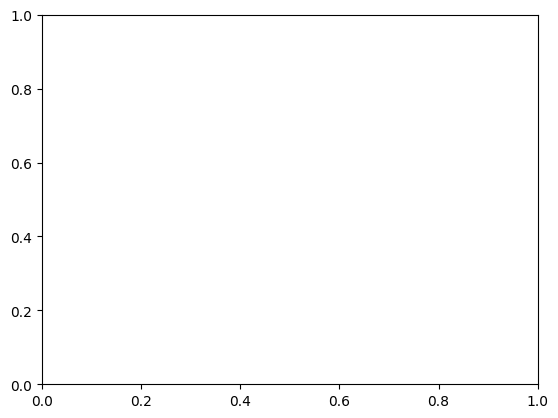

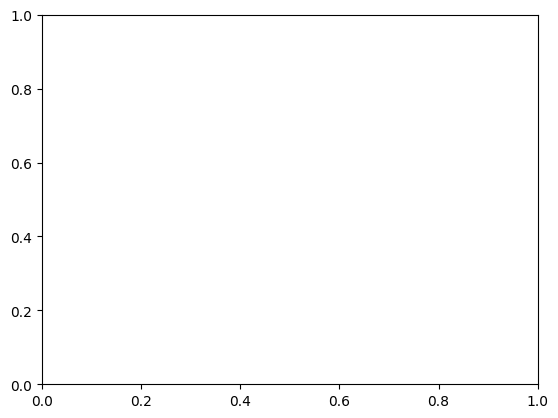

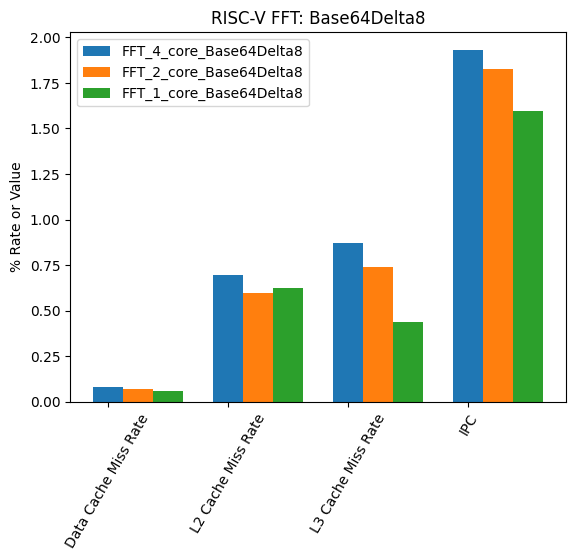

('FFT', '4_core', 'Base64Delta16') [0.07792675, 0.69613225, 0.874391, 1.9297377500000001]
('FFT', '2_core', 'Base64Delta16') [0.0667715, 0.595182, 0.739778, 1.823887]
('FFT', '1_core', 'Base64Delta16') [0.058591, 0.626484, 0.439788, 1.598053]


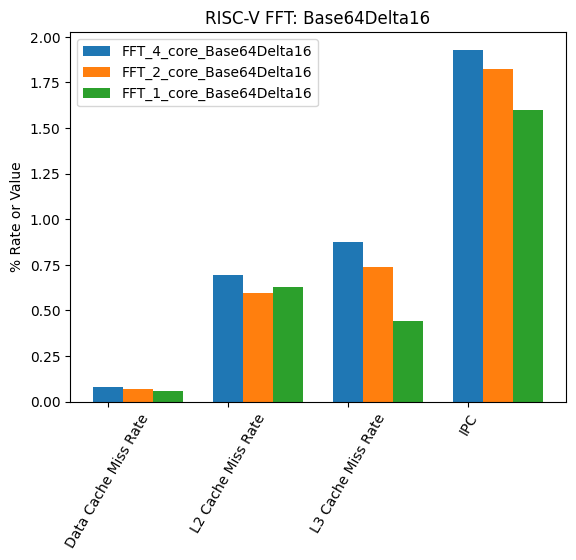

('FFT', '4_core', 'Base64Delta32') [0.07793725, 0.69591625, 0.873701, 1.9310097500000003]
('FFT', '2_core', 'Base64Delta32') [0.0667715, 0.595182, 0.739778, 1.823887]
('FFT', '1_core', 'Base64Delta32') [0.058602, 0.626482, 0.439792, 1.598053]


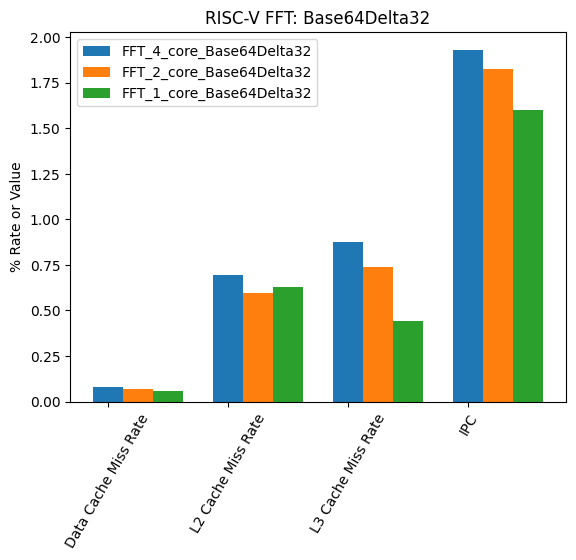

('FFT', '4_core', 'Base32Delta8') [0.077911, 0.6957962500000001, 0.873453, 1.9327717500000001]
('FFT', '2_core', 'Base32Delta8') [0.0667715, 0.595182, 0.739778, 1.823886]
('FFT', '1_core', 'Base32Delta8') [0.058606, 0.626484, 0.439788, 1.598053]


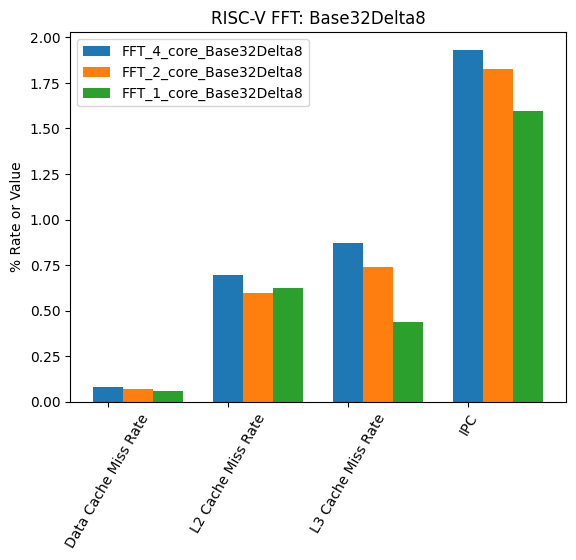

('FFT', '4_core', 'Base32Delta16') [0.07793725, 0.69591625, 0.873701, 1.9310097500000003]
('FFT', '2_core', 'Base32Delta16') [0.0667715, 0.595182, 0.739778, 1.823887]
('FFT', '1_core', 'Base32Delta16') [0.058602, 0.626482, 0.439792, 1.598053]


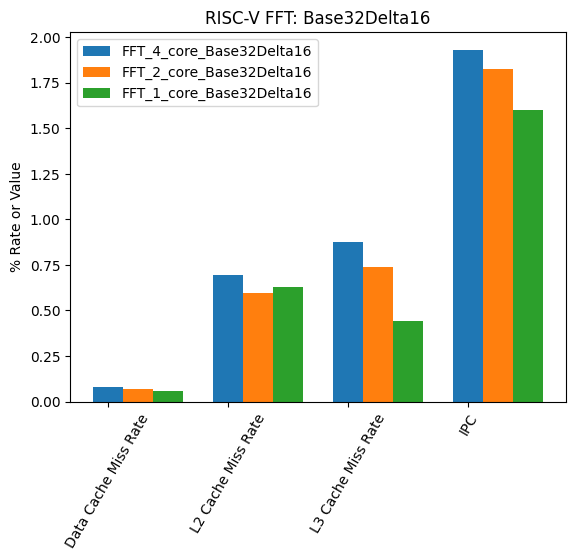

('FFT', '4_core', 'Base16Delta8') [0.07793725, 0.69591625, 0.873701, 1.9310097500000003]
('FFT', '2_core', 'Base16Delta8') [0.0667715, 0.595182, 0.739778, 1.823887]
('FFT', '1_core', 'Base16Delta8') [0.058602, 0.626482, 0.439792, 1.598053]


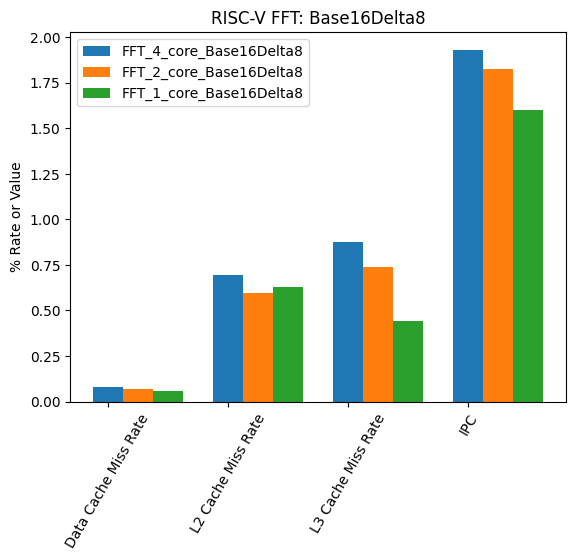

('FFT', '4_core', 'CPack') [0.0779115, 0.69609075, 0.874658, 1.9334482499999999]
('FFT', '2_core', 'CPack') [0.0667885, 0.5952565, 0.739674, 1.823648]
('FFT', '1_core', 'CPack') [0.058588, 0.626488, 0.43978, 1.598014]


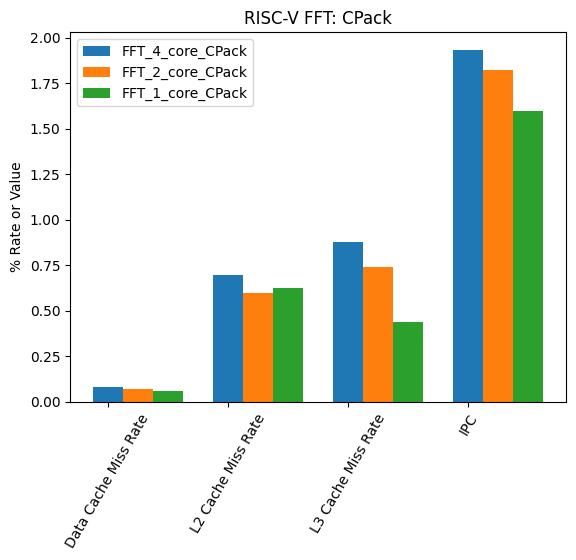

('FFT', '4_core', 'FPC') [0.0778865, 0.6961115, 0.874378, 1.9286254999999999]
('FFT', '2_core', 'FPC') [0.066771, 0.595182, 0.739778, 1.82388]
('FFT', '1_core', 'FPC') [0.058601, 0.626484, 0.439788, 1.598036]


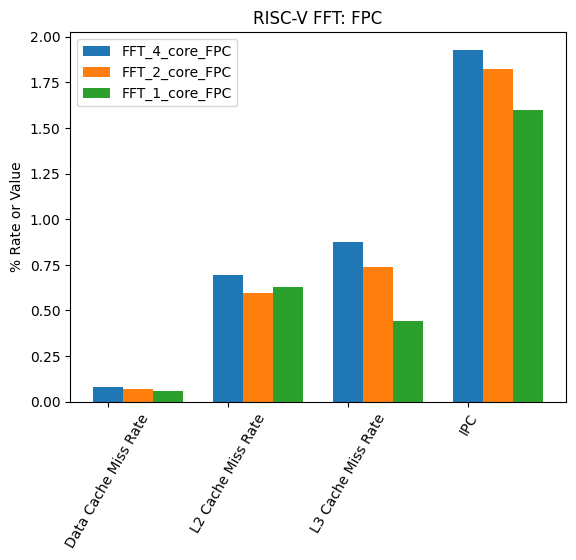

('FFT', '4_core', 'FPCD') [0.07779475, 0.696014, 0.874582, 1.9335339999999999]
('FFT', '2_core', 'FPCD') [0.0670405, 0.5941985000000001, 0.741271, 1.824564]
('FFT', '1_core', 'FPCD') [0.058589, 0.626484, 0.439788, 1.598037]


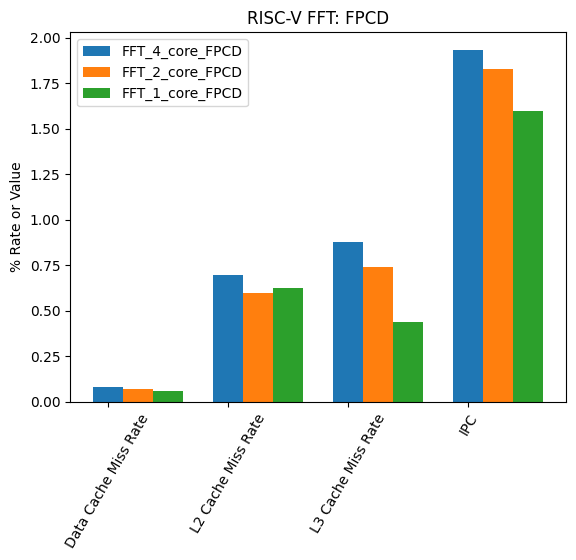

('FFT', '4_core', 'FrequentValuesCompressor') [0.0778915, 0.69602425, 0.874052, 1.9325999999999999]
('FFT', '2_core', 'FrequentValuesCompressor') [0.066839, 0.5951985, 0.73952, 1.8238205]
('FFT', '1_core', 'FrequentValuesCompressor') [0.058588, 0.626484, 0.439788, 1.598016]


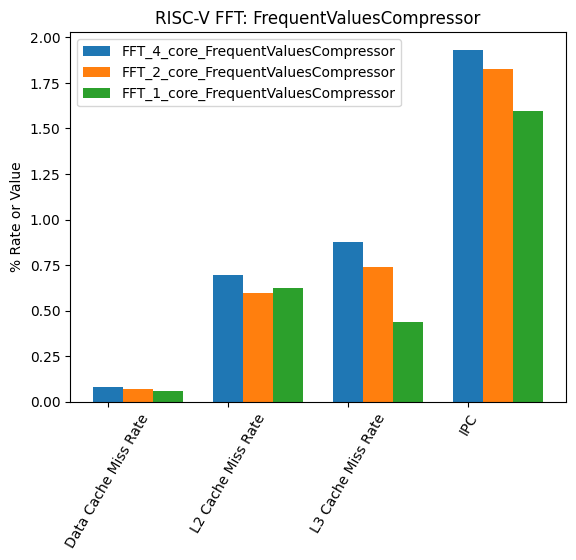

('FFT', '4_core', 'MultiCompressor') [0.07783525, 0.6960007500000001, 0.874701, 1.9332859999999998]
('FFT', '2_core', 'MultiCompressor') [0.06684, 0.595221, 0.739818, 1.8238089999999998]
('FFT', '1_core', 'MultiCompressor') [0.058588, 0.626488, 0.43978, 1.598029]


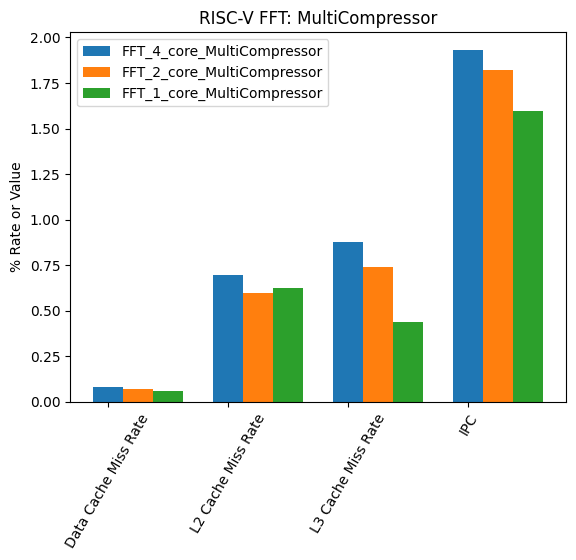

('FFT', '4_core', 'PerfectCompressor') []
failed to plot:  PerfectCompressor
('FFT', '4_core', 'RepeatedQwordsCompressor') [0.07786900000000001, 0.6958515, 0.873696, 1.93119675]
('FFT', '2_core', 'RepeatedQwordsCompressor') [0.0667715, 0.595182, 0.739778, 1.823886]
('FFT', '1_core', 'RepeatedQwordsCompressor') [0.058588, 0.626482, 0.439792, 1.598053]


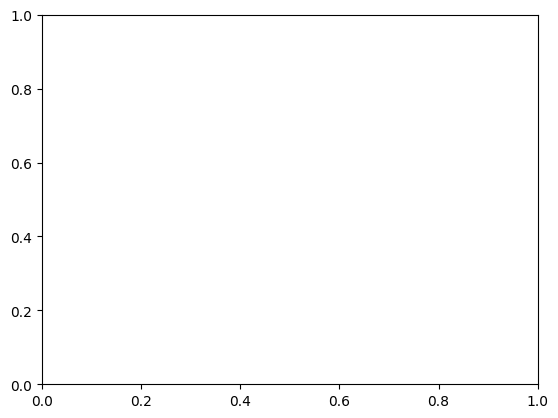

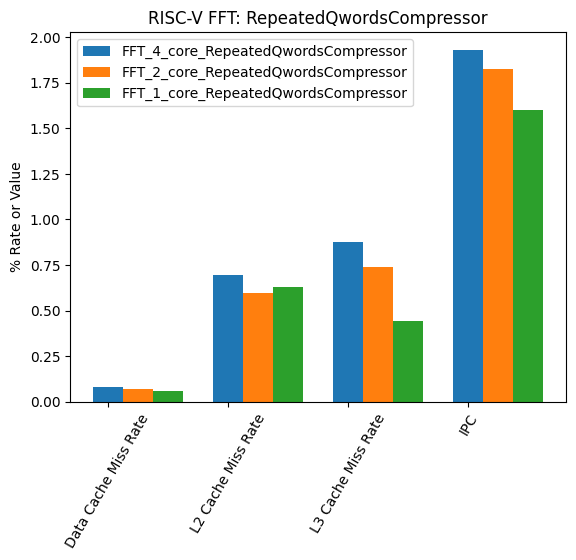

('FFT', '4_core', 'ZeroCompressor') [0.07786900000000001, 0.6958515, 0.873696, 1.93119675]
('FFT', '2_core', 'ZeroCompressor') [0.0667715, 0.595182, 0.739778, 1.823886]
('FFT', '1_core', 'ZeroCompressor') [0.058588, 0.626482, 0.439792, 1.598053]


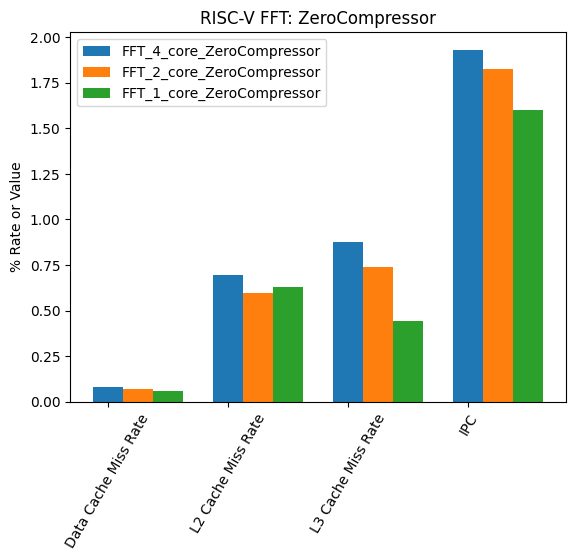

('FFT', '4_core', 'BDI') [0.07792675, 0.69613225, 0.874391, 1.9297377500000001]
('FFT', '2_core', 'BDI') [0.0667715, 0.595182, 0.739778, 1.823887]
('FFT', '1_core', 'BDI') [0.058591, 0.626484, 0.439788, 1.598053]


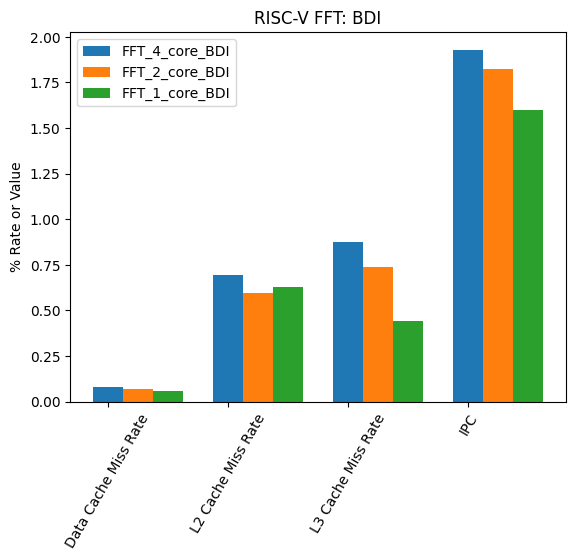

('FFT', '4_core', 'no_compression') [0.07793725, 0.69591625, 0.873701, 1.9310097500000003]
('FFT', '2_core', 'no_compression') [0.0667715, 0.595182, 0.739778, 1.823887]
('FFT', '1_core', 'no_compression') [0.058602, 0.626482, 0.439792, 1.598053]


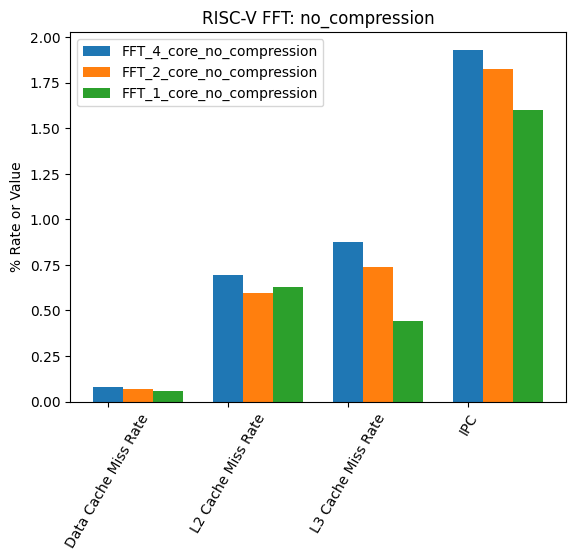

('LU', '4_core', 'BaseCacheCompressor') []
failed to plot:  BaseCacheCompressor
('LU', '4_core', 'BaseDictionaryCompressor') []
failed to plot:  BaseDictionaryCompressor
('LU', '4_core', 'Base64Delta8') [0.007112, 0.1591535, 0.802225, 0.8656282500000001]
('LU', '2_core', 'Base64Delta8') [0.0069440000000000005, 0.106306, 0.767472, 0.8695729999999999]
('LU', '1_core', 'Base64Delta8') [0.006421, 0.055871, 0.757348, 0.874463]


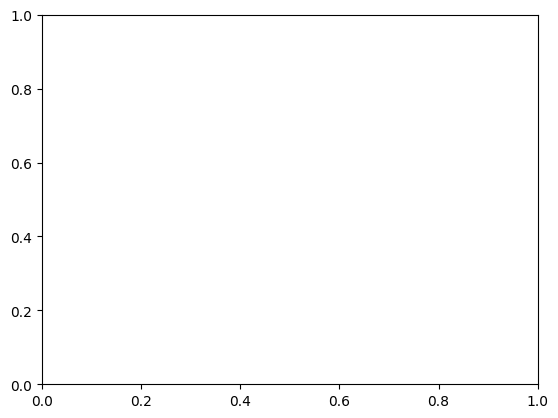

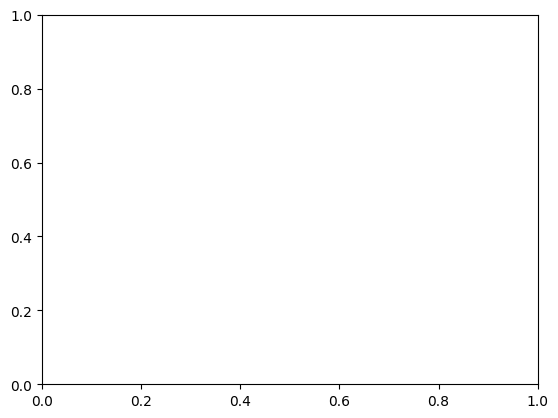

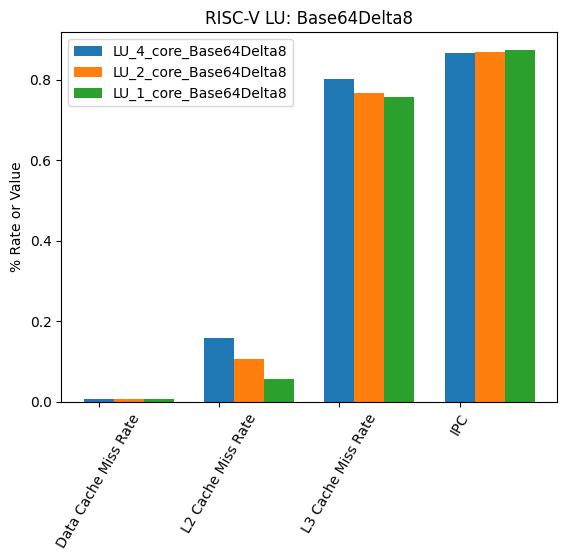

('LU', '4_core', 'Base64Delta16') [0.007112, 0.1591535, 0.802225, 0.8656282500000001]
('LU', '2_core', 'Base64Delta16') [0.0069440000000000005, 0.106306, 0.767472, 0.8695729999999999]
('LU', '1_core', 'Base64Delta16') [0.006421, 0.055871, 0.757348, 0.874463]


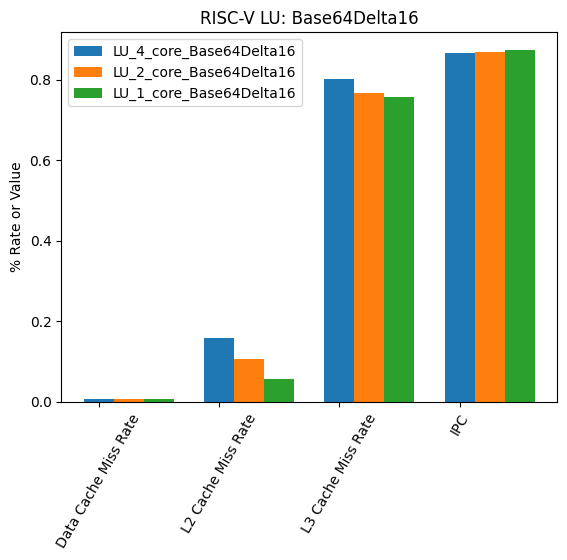

('LU', '4_core', 'Base64Delta32') [0.007112, 0.1591535, 0.802225, 0.8656282500000001]
('LU', '2_core', 'Base64Delta32') [0.0069440000000000005, 0.106307, 0.767477, 0.8695729999999999]
('LU', '1_core', 'Base64Delta32') [0.006421, 0.055871, 0.757348, 0.874463]


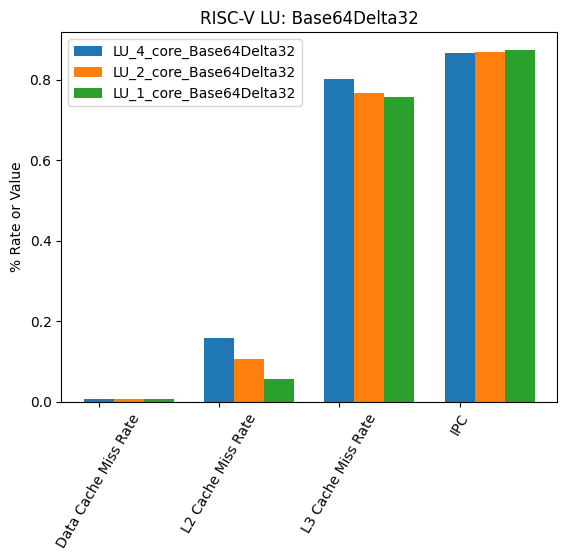

('LU', '4_core', 'Base32Delta8') [0.007112, 0.1591535, 0.802225, 0.8656282500000001]
('LU', '2_core', 'Base32Delta8') [0.0069440000000000005, 0.106306, 0.767472, 0.8695729999999999]
('LU', '1_core', 'Base32Delta8') [0.006421, 0.055871, 0.757348, 0.874463]


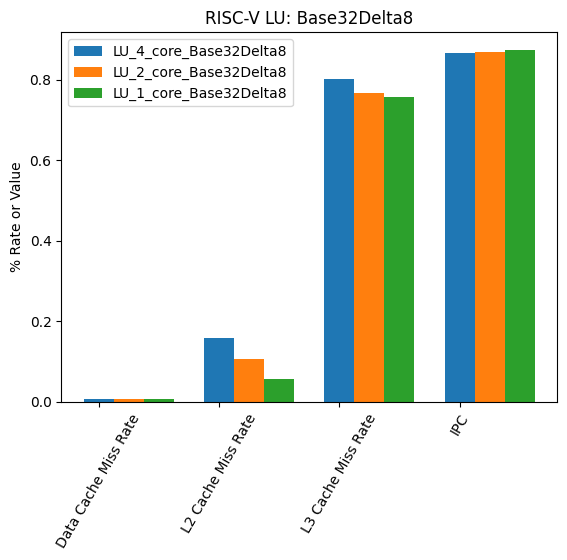

('LU', '4_core', 'Base32Delta16') [0.007112, 0.1591535, 0.802225, 0.8656282500000001]
('LU', '2_core', 'Base32Delta16') [0.0069440000000000005, 0.106307, 0.767477, 0.8695729999999999]
('LU', '1_core', 'Base32Delta16') [0.006421, 0.055871, 0.757348, 0.874463]


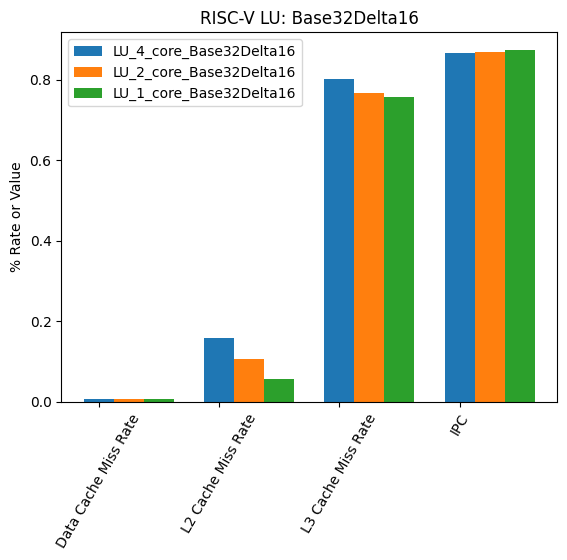

('LU', '4_core', 'Base16Delta8') [0.007112, 0.1591535, 0.802225, 0.8656282500000001]
('LU', '2_core', 'Base16Delta8') [0.0069440000000000005, 0.106307, 0.767477, 0.8695729999999999]
('LU', '1_core', 'Base16Delta8') [0.006421, 0.055871, 0.757348, 0.874463]


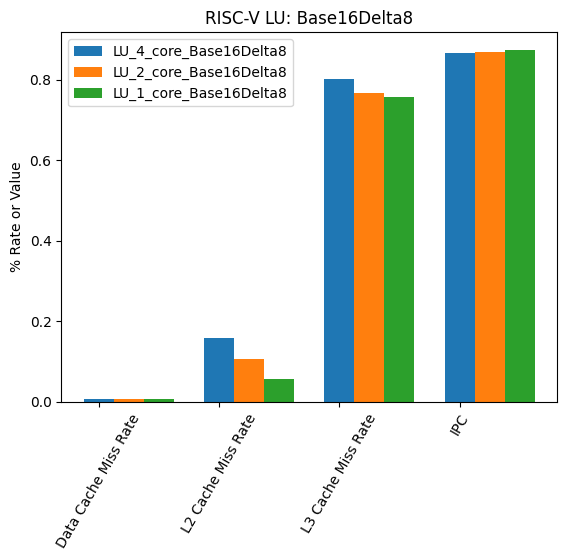

('LU', '4_core', 'CPack') [0.00711675, 0.15948800000000002, 0.797926, 0.86554025]
('LU', '2_core', 'CPack') [0.0069440000000000005, 0.106307, 0.767477, 0.8695725]
('LU', '1_core', 'CPack') [0.006421, 0.055871, 0.757348, 0.874475]


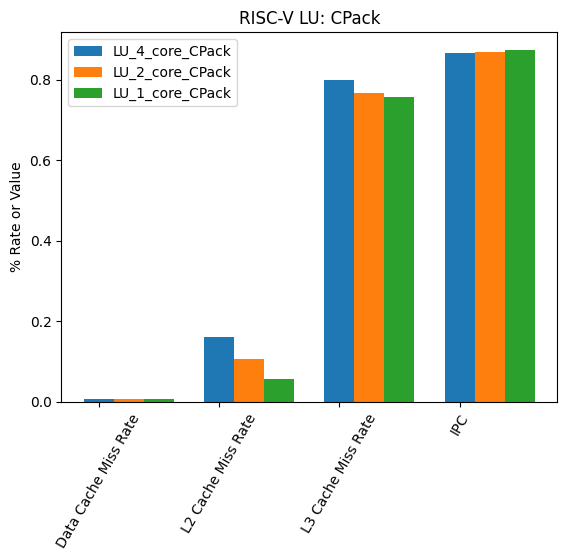

('LU', '4_core', 'FPC') [0.00711775, 0.15949175, 0.79813, 0.8654935]
('LU', '2_core', 'FPC') [0.0069440000000000005, 0.106306, 0.767472, 0.8695729999999999]
('LU', '1_core', 'FPC') [0.006421, 0.055873, 0.757336, 0.874461]


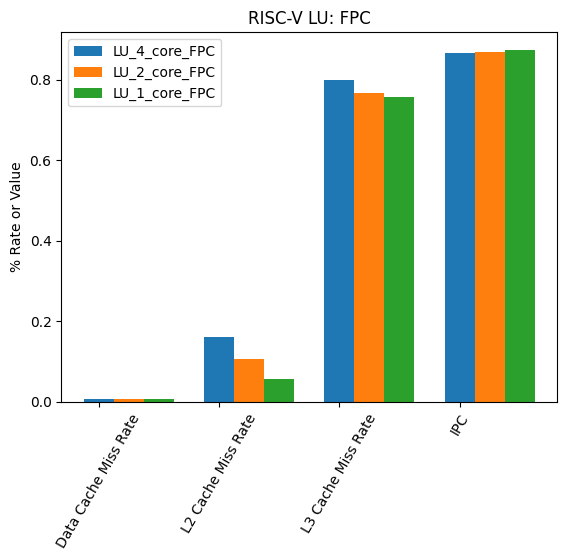

('LU', '4_core', 'FPCD') [0.007116249999999999, 0.15943825, 0.79833, 0.8654934999999999]
('LU', '2_core', 'FPCD') [0.0069440000000000005, 0.106306, 0.767472, 0.8695729999999999]
('LU', '1_core', 'FPCD') [0.006421, 0.055871, 0.757348, 0.874461]


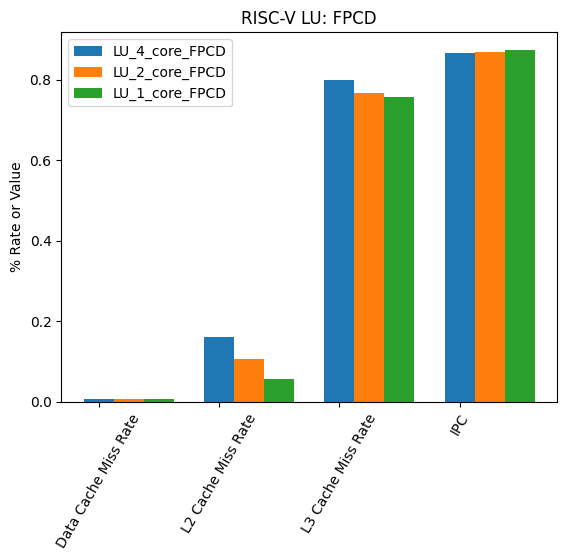

('LU', '4_core', 'FrequentValuesCompressor') [0.0071129999999999995, 0.15920575000000003, 0.800854, 0.865534]
('LU', '2_core', 'FrequentValuesCompressor') [0.0069440000000000005, 0.106307, 0.767477, 0.8695725]
('LU', '1_core', 'FrequentValuesCompressor') [0.006421, 0.055871, 0.757348, 0.874438]


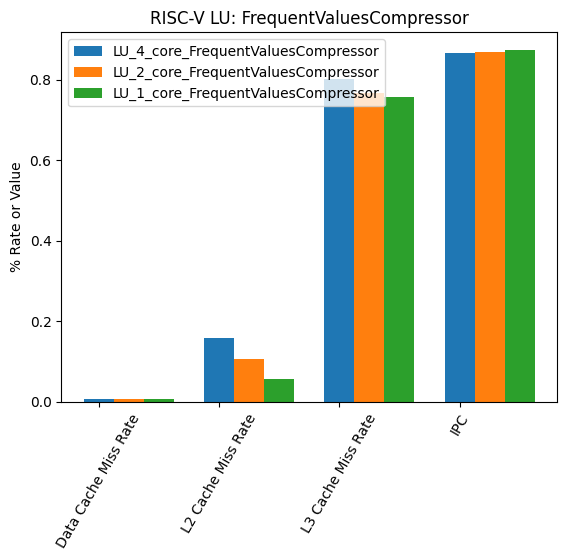

('LU', '4_core', 'MultiCompressor') [0.00711675, 0.15948800000000002, 0.797944, 0.8655405]
('LU', '2_core', 'MultiCompressor') [0.0069440000000000005, 0.106306, 0.767472, 0.8695725]
('LU', '1_core', 'MultiCompressor') [0.006421, 0.055871, 0.757348, 0.874458]


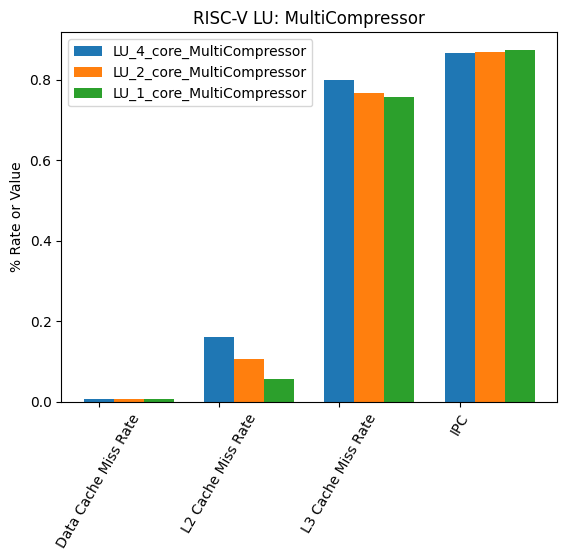

('LU', '4_core', 'PerfectCompressor') []
failed to plot:  PerfectCompressor
('LU', '4_core', 'RepeatedQwordsCompressor') [0.007112, 0.1591535, 0.802225, 0.8656282500000001]
('LU', '2_core', 'RepeatedQwordsCompressor') [0.0069440000000000005, 0.106307, 0.767477, 0.8695729999999999]
('LU', '1_core', 'RepeatedQwordsCompressor') [0.006421, 0.055871, 0.757348, 0.874463]


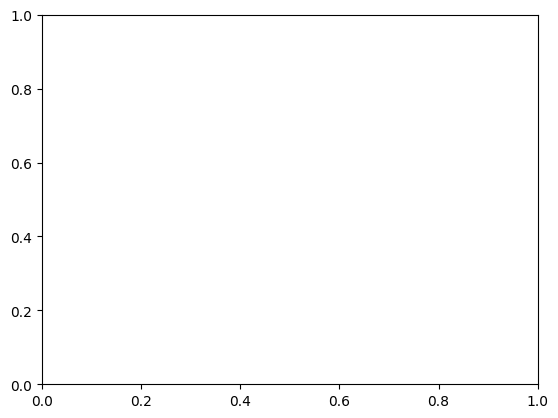

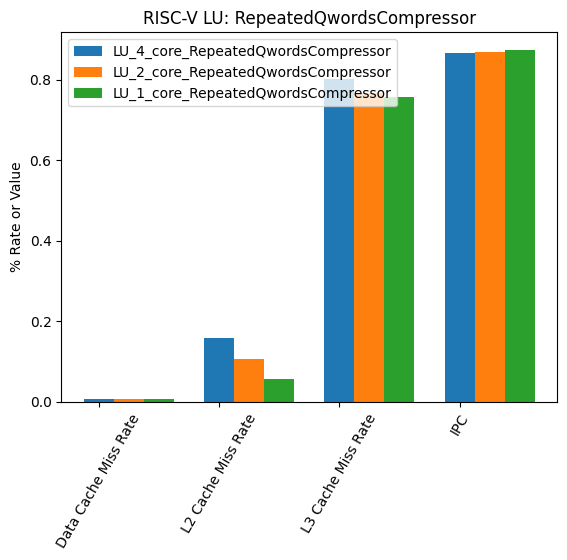

('LU', '4_core', 'ZeroCompressor') [0.007112, 0.1591535, 0.802225, 0.8656282500000001]
('LU', '2_core', 'ZeroCompressor') [0.0069440000000000005, 0.106307, 0.767477, 0.8695729999999999]
('LU', '1_core', 'ZeroCompressor') [0.006421, 0.055871, 0.757348, 0.874463]


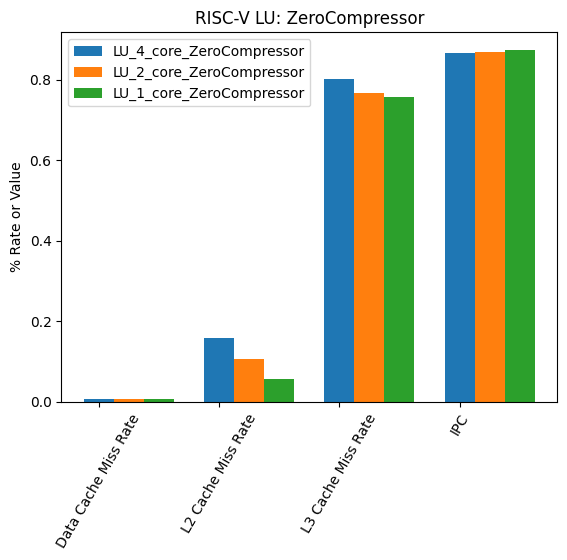

('LU', '4_core', 'BDI') [0.007112, 0.1591535, 0.802225, 0.8656282500000001]
('LU', '2_core', 'BDI') [0.0069440000000000005, 0.106306, 0.767472, 0.8695729999999999]
('LU', '1_core', 'BDI') [0.006421, 0.055871, 0.757348, 0.874463]


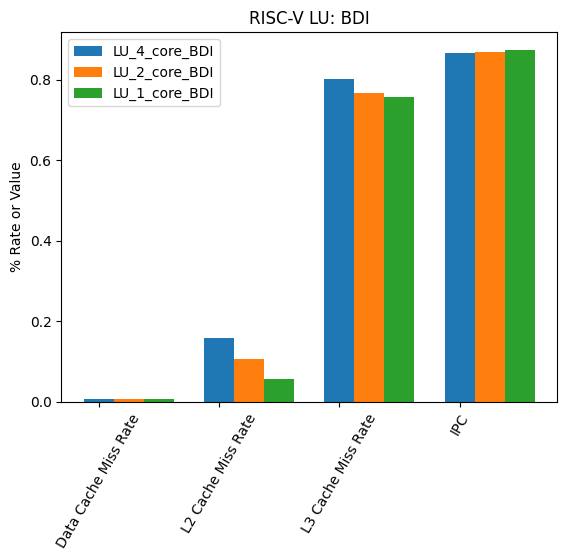

('LU', '4_core', 'no_compression') [0.007112, 0.1591535, 0.802225, 0.8656282500000001]
('LU', '2_core', 'no_compression') [0.0069440000000000005, 0.106307, 0.767477, 0.8695729999999999]
('LU', '1_core', 'no_compression') [0.006421, 0.055871, 0.757348, 0.874463]


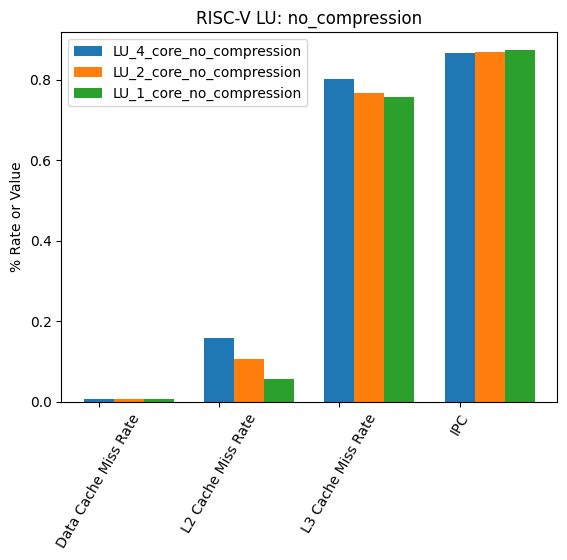

('RADIX', '4_core', 'BaseCacheCompressor') []
failed to plot:  BaseCacheCompressor
('RADIX', '4_core', 'BaseDictionaryCompressor') []
failed to plot:  BaseDictionaryCompressor
('RADIX', '4_core', 'Base64Delta8') []
failed to plot:  Base64Delta8
('RADIX', '4_core', 'Base64Delta16') []
failed to plot:  Base64Delta16
('RADIX', '4_core', 'Base64Delta32') []
failed to plot:  Base64Delta32
('RADIX', '4_core', 'Base32Delta8') []
failed to plot:  Base32Delta8
('RADIX', '4_core', 'Base32Delta16') []
failed to plot:  Base32Delta16
('RADIX', '4_core', 'Base16Delta8') []
failed to plot:  Base16Delta8
('RADIX', '4_core', 'CPack') []
failed to plot:  CPack
('RADIX', '4_core', 'FPC') []
failed to plot:  FPC
('RADIX', '4_core', 'FPCD') []
failed to plot:  FPCD
('RADIX', '2_core', 'FrequentValuesCompressor') [0.143574, 0.48149149999999996, 0.954156, 0.5408255]
('RADIX', '1_core', 'FrequentValuesCompressor') [0.143666, 0.480881, 0.969162, 0.552571]
('RADIX', '4', 'FrequentValuesCompressor') []
failed to

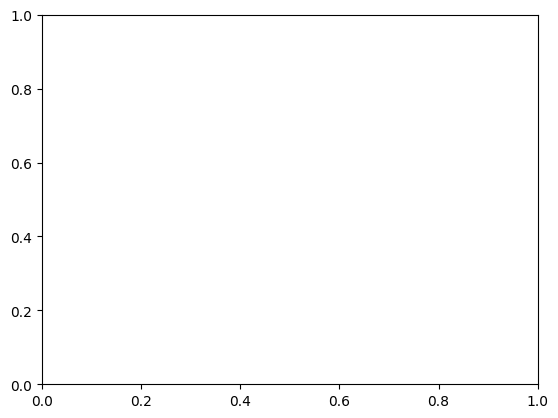

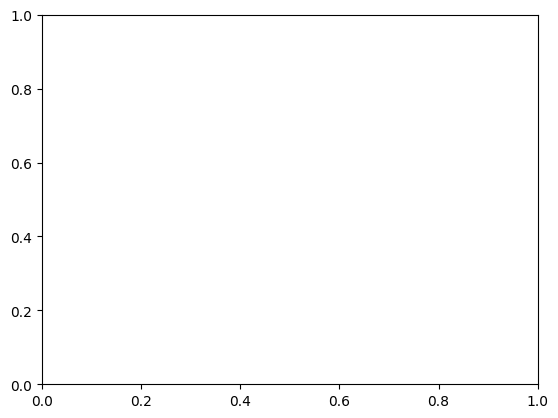

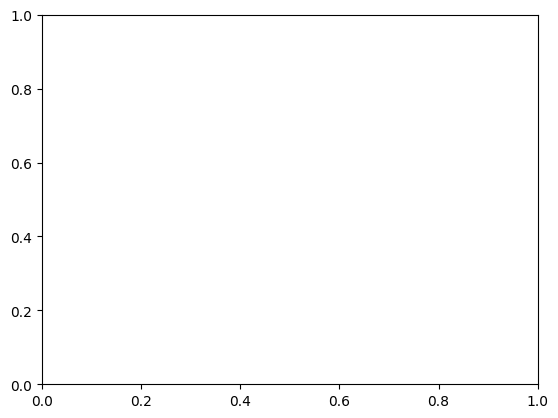

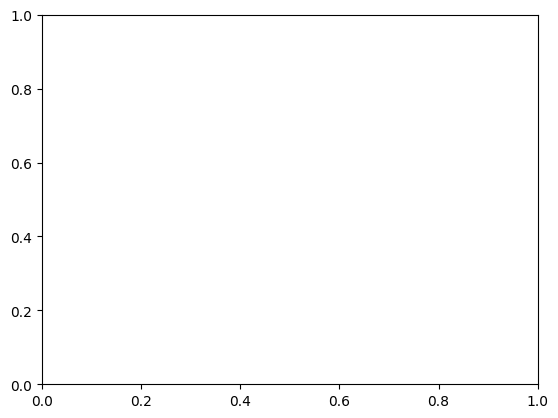

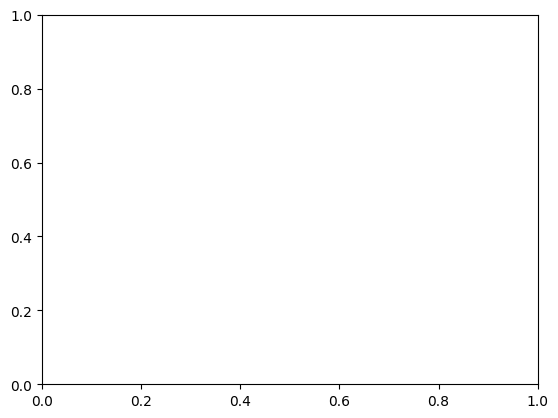

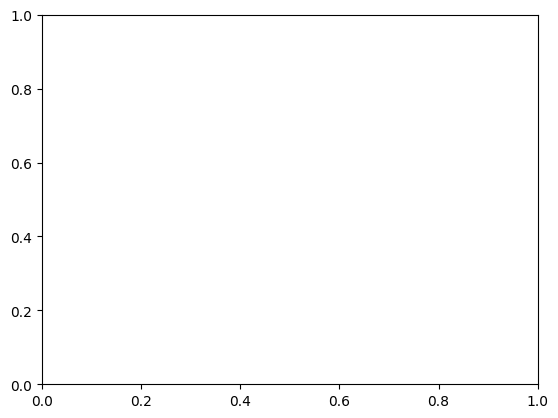

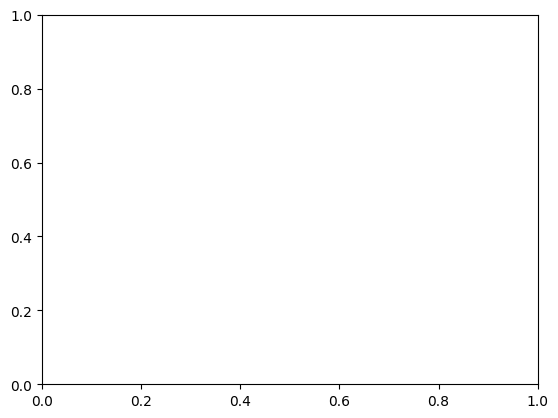

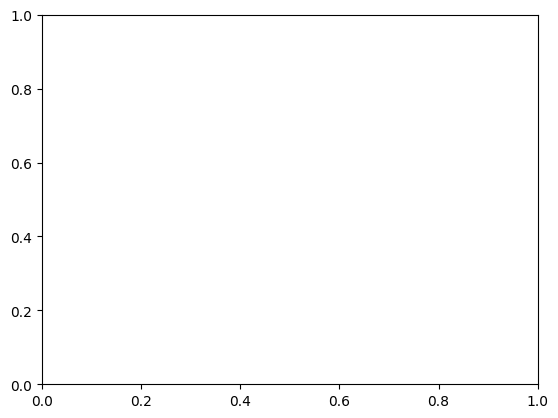

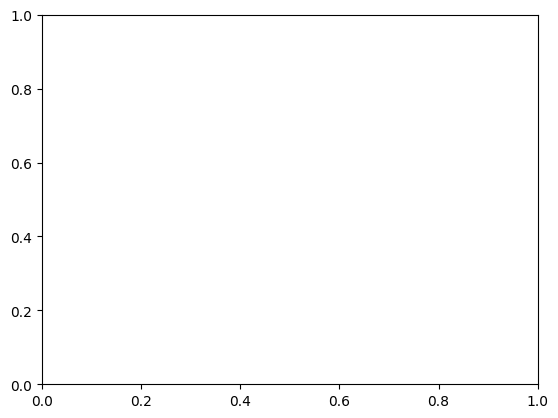

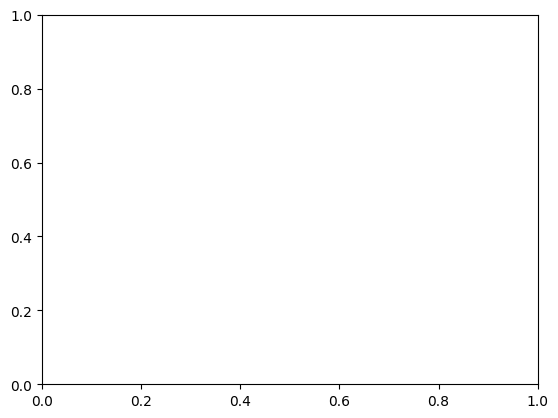

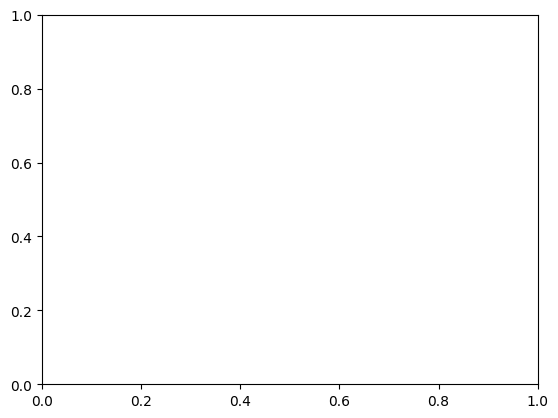

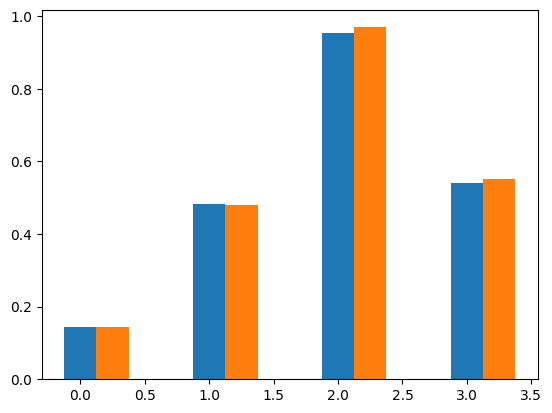

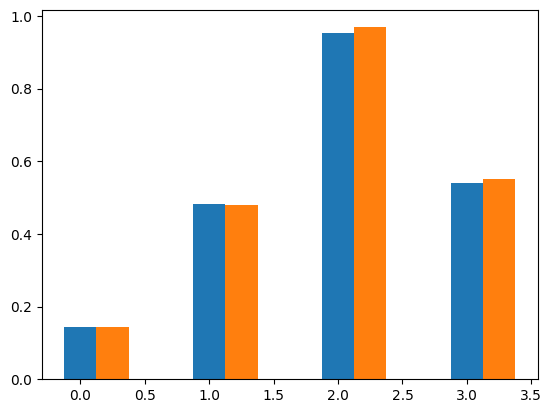

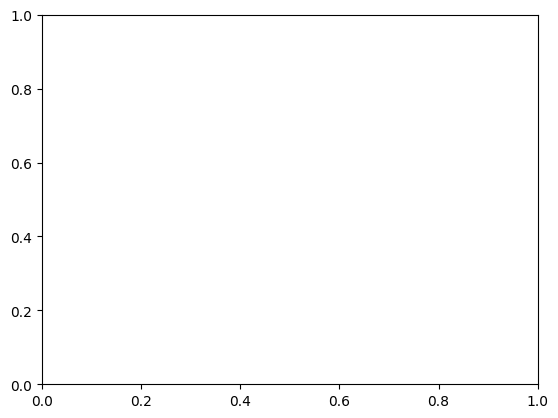

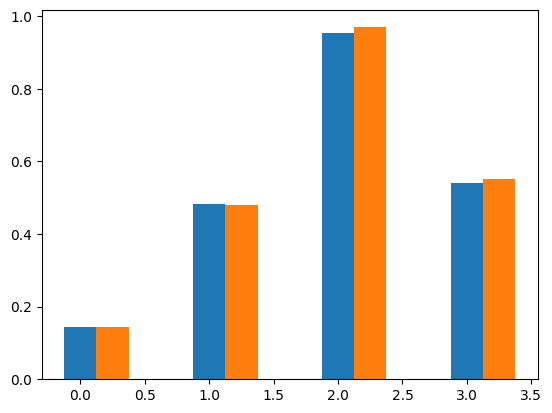

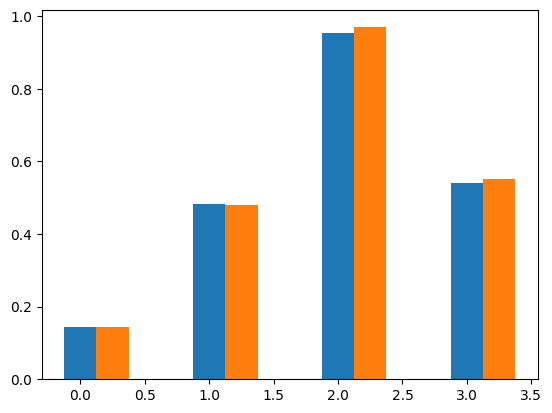

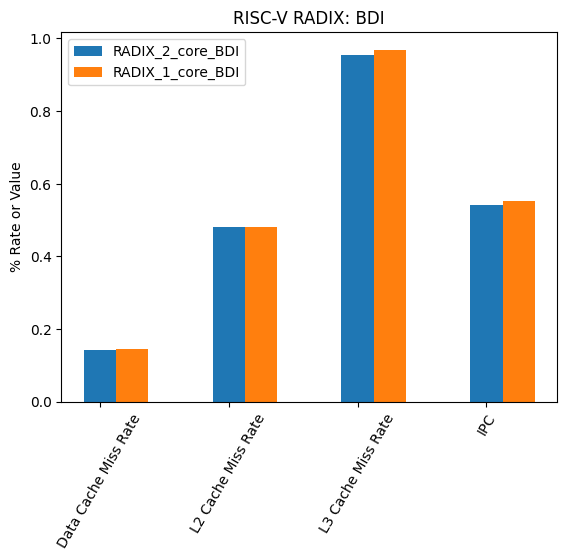

('RADIX', '2_core', 'no_compression') [0.14358949999999998, 0.48145000000000004, 0.954848, 0.5397540000000001]
('RADIX', '1_core', 'no_compression') [0.143664, 0.480881, 0.970452, 0.553227]


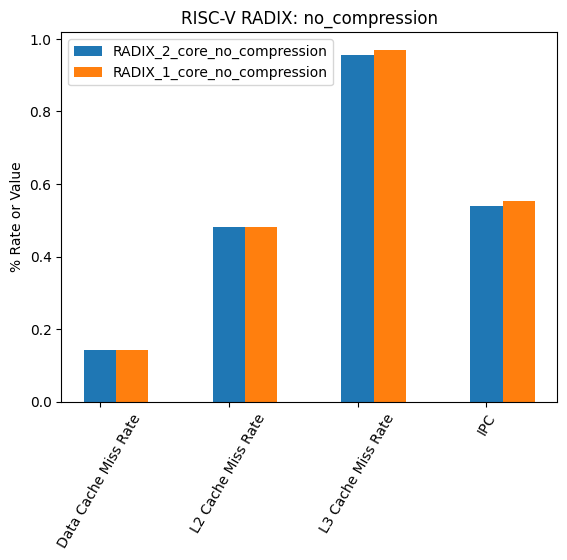

In [25]:
all_compressors = [
    'BaseCacheCompressor', 'BaseDictionaryCompressor',
    'Base64Delta8', 'Base64Delta16', 'Base64Delta32',
    'Base32Delta8', 'Base32Delta16', 'Base16Delta8',
    'CPack', 'FPC', 'FPCD', 'FrequentValuesCompressor', 'MultiCompressor',
    'PerfectCompressor', 'RepeatedQwordsCompressor', 'ZeroCompressor', 'BDI', 'no_compression']

progs = ["FFT", "LU", "RADIX"]

for p in progs:
    for compressor in all_compressors:
        try:
            plot_benchmark(compressor, p, riscv_wanted_metrics, "RISC-V")
        except:
            print("failed to plot: ", compressor)


('FFT', '4_core', 'BaseCacheCompressor') []
failed to plot:  BaseCacheCompressor
('FFT', '4_core', 'BaseDictionaryCompressor') []
failed to plot:  BaseDictionaryCompressor
('FFT', '4_core', 'Base64Delta8') [0.06711225, 0.7027239999999999, 0.863033, 1.5462005]
('FFT', '2_core', 'Base64Delta8') [0.0520645, 0.604177, 0.754585, 1.5636075]
('FFT', '1_core', 'Base64Delta8') [0.029289, 0.628338, 0.460246, 1.54521]


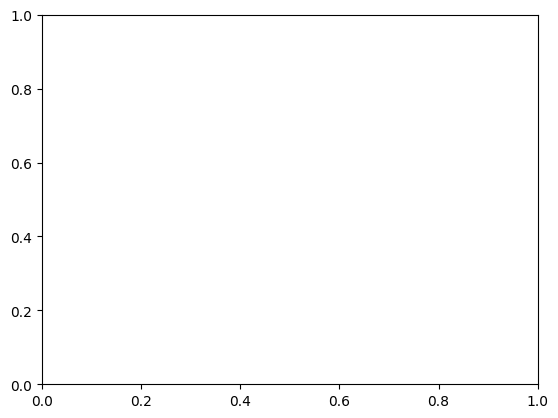

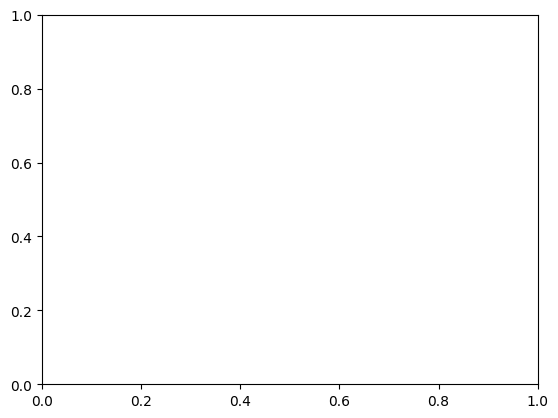

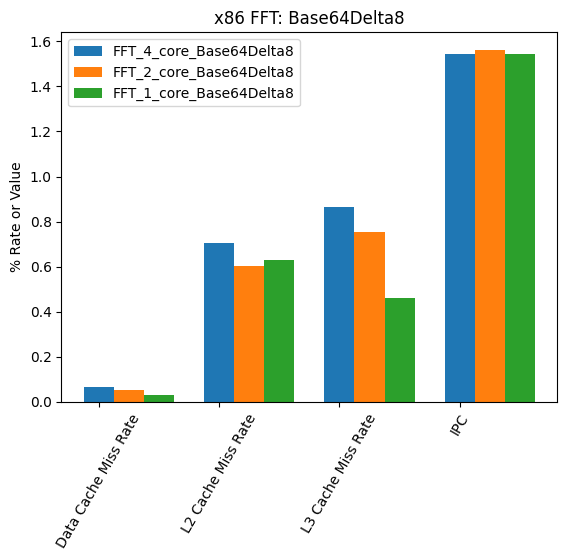

('FFT', '4_core', 'Base64Delta16') [0.06711199999999999, 0.7027239999999999, 0.863033, 1.54620075]
('FFT', '2_core', 'Base64Delta16') [0.0520645, 0.604177, 0.754585, 1.5636075]
('FFT', '1_core', 'Base64Delta16') [0.029289, 0.628338, 0.460246, 1.54521]


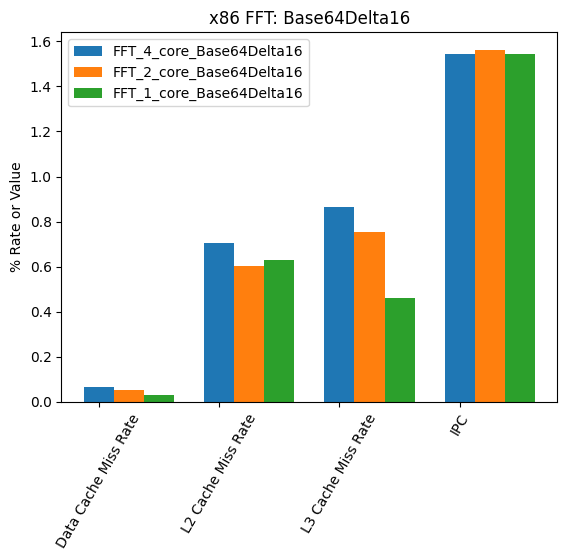

('FFT', '4_core', 'Base64Delta32') [0.06711075, 0.7027604999999999, 0.862833, 1.5461945]
('FFT', '2_core', 'Base64Delta32') [0.052064, 0.6041885, 0.754606, 1.5635815]
('FFT', '1_core', 'Base64Delta32') [0.029289, 0.628338, 0.460246, 1.54521]


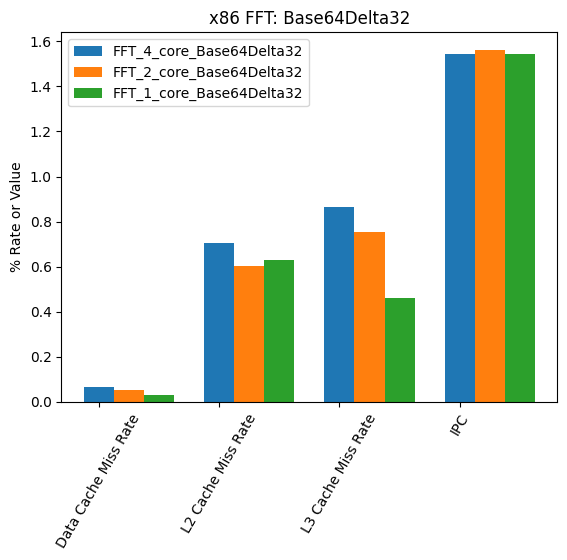

('FFT', '4_core', 'Base32Delta8') [0.06711275, 0.7027245, 0.863046, 1.5461835000000002]
('FFT', '2_core', 'Base32Delta8') [0.052064, 0.6041885, 0.754606, 1.563635]
('FFT', '1_core', 'Base32Delta8') [0.029289, 0.628338, 0.460246, 1.54521]


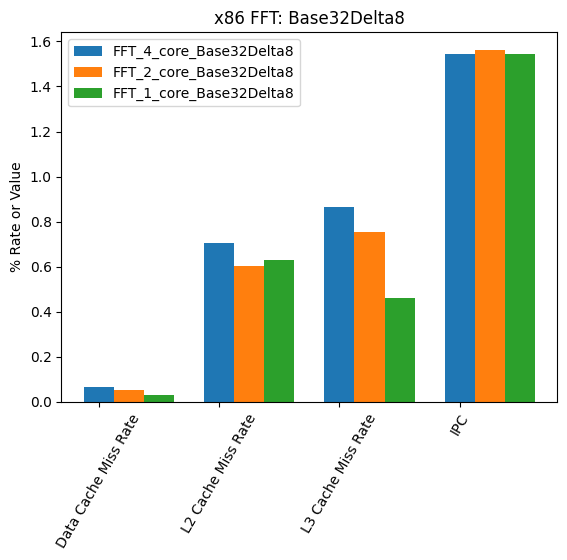

('FFT', '4_core', 'Base32Delta16') [0.06711075, 0.7027604999999999, 0.862833, 1.5461945]
('FFT', '2_core', 'Base32Delta16') [0.052064, 0.6041885, 0.754606, 1.5635815]
('FFT', '1_core', 'Base32Delta16') [0.029289, 0.628338, 0.460246, 1.54521]


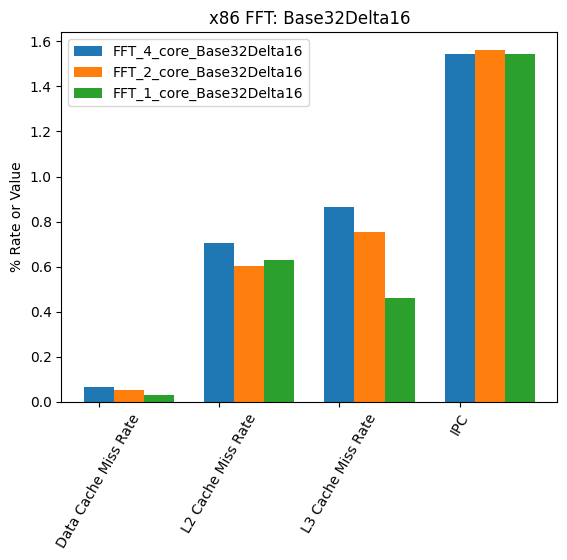

('FFT', '4_core', 'Base16Delta8') [0.06711075, 0.7027604999999999, 0.862833, 1.5461945]
('FFT', '2_core', 'Base16Delta8') [0.052064, 0.6041885, 0.754606, 1.5635815]
('FFT', '1_core', 'Base16Delta8') [0.029289, 0.628338, 0.460246, 1.54521]


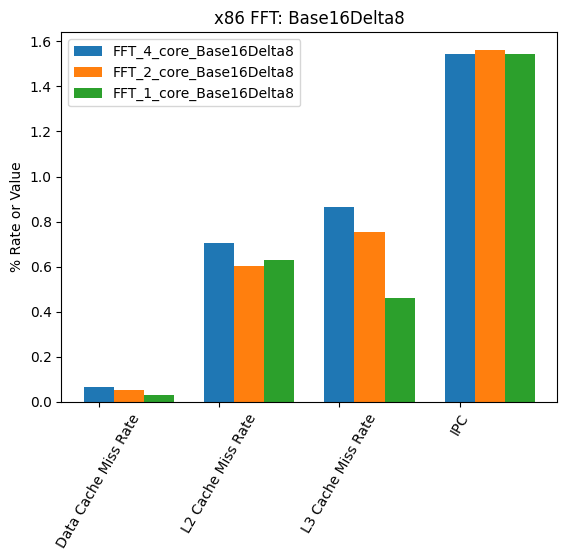

('FFT', '4_core', 'CPack') [0.06711225, 0.7027539999999999, 0.862846, 1.5461049999999998]
('FFT', '2_core', 'CPack') [0.052065, 0.604174, 0.754585, 1.5636619999999999]
('FFT', '1_core', 'CPack') [0.02929, 0.628251, 0.460296, 1.545176]


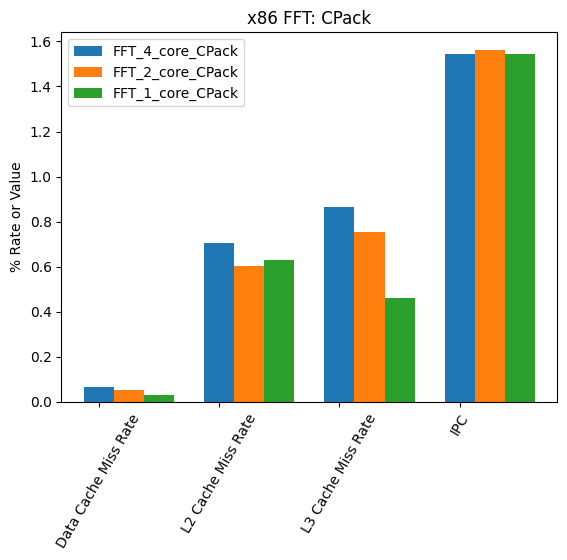

('FFT', '4_core', 'FPC') [0.06709975, 0.7027807500000001, 0.861608, 1.5452854999999999]
('FFT', '2_core', 'FPC') [0.052064, 0.6041855, 0.754606, 1.5636105]
('FFT', '1_core', 'FPC') [0.029289, 0.628332, 0.460258, 1.545176]


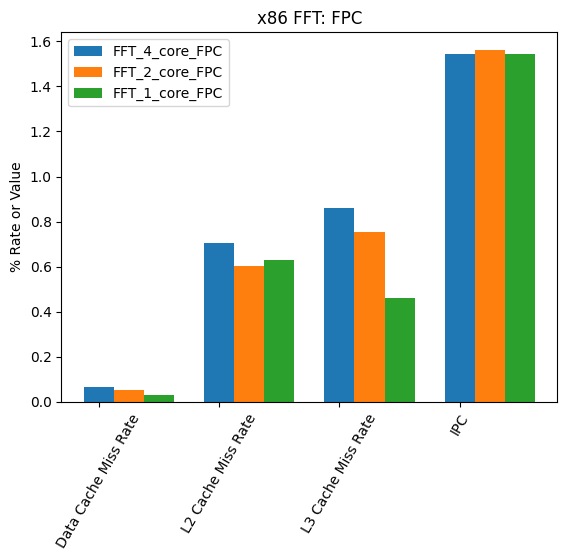

('FFT', '4_core', 'FPCD') [0.067124, 0.70284, 0.862251, 1.54603375]
('FFT', '2_core', 'FPCD') [0.052065, 0.604177, 0.754585, 1.563602]
('FFT', '1_core', 'FPCD') [0.029289, 0.628286, 0.460281, 1.545176]


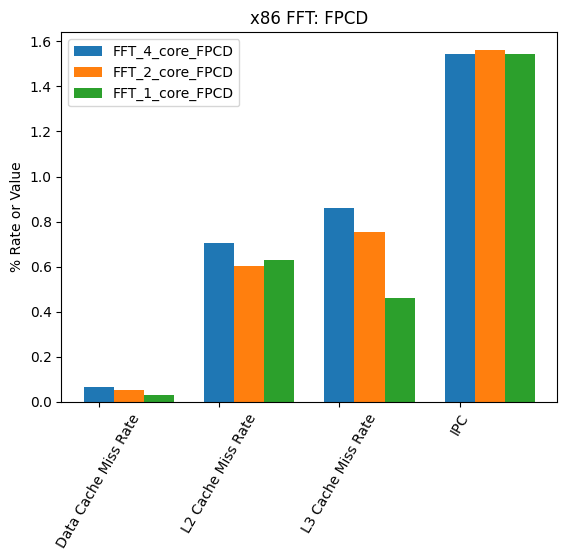

('FFT', '4_core', 'FrequentValuesCompressor') [0.0671115, 0.7027235000000001, 0.863019, 1.54620625]
('FFT', '2_core', 'FrequentValuesCompressor') [0.052065, 0.6041829999999999, 0.754606, 1.563671]
('FFT', '1_core', 'FrequentValuesCompressor') [0.02929, 0.628324, 0.460254, 1.545175]


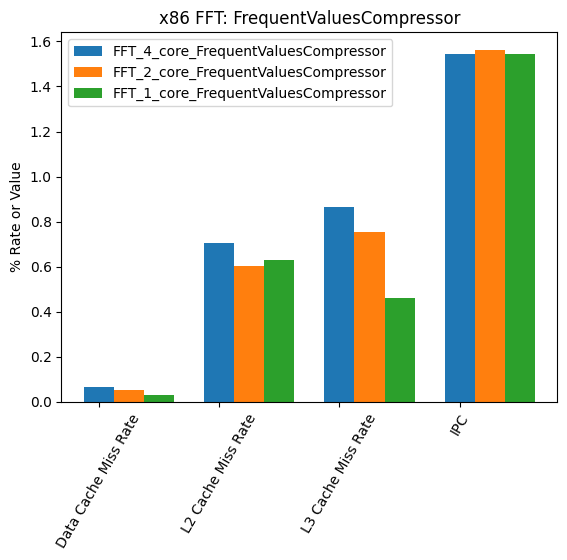

('FFT', '4_core', 'MultiCompressor') [0.06710125, 0.70299325, 0.861784, 1.54635325]
('FFT', '2_core', 'MultiCompressor') [0.052065, 0.604174, 0.754585, 1.5636755]
('FFT', '1_core', 'MultiCompressor') [0.029289, 0.628329, 0.460258, 1.545176]


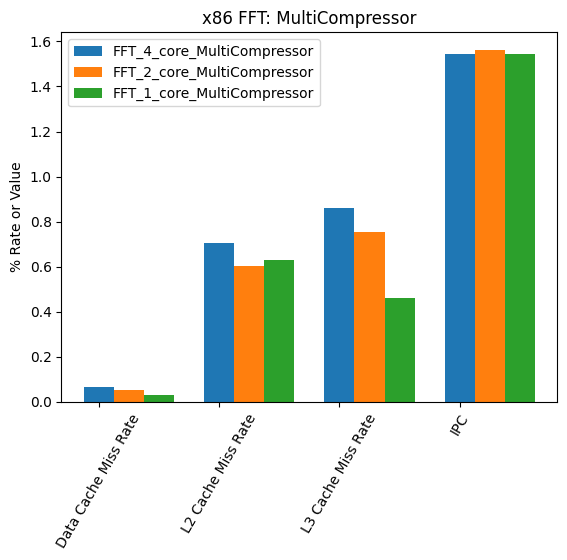

('FFT', '4_core', 'PerfectCompressor') []
failed to plot:  PerfectCompressor
('FFT', '4_core', 'RepeatedQwordsCompressor') [0.06711075, 0.7027604999999999, 0.862833, 1.5461945]
('FFT', '2_core', 'RepeatedQwordsCompressor') [0.052064, 0.6041885, 0.754606, 1.5635815]
('FFT', '1_core', 'RepeatedQwordsCompressor') [0.029289, 0.628338, 0.460246, 1.54521]


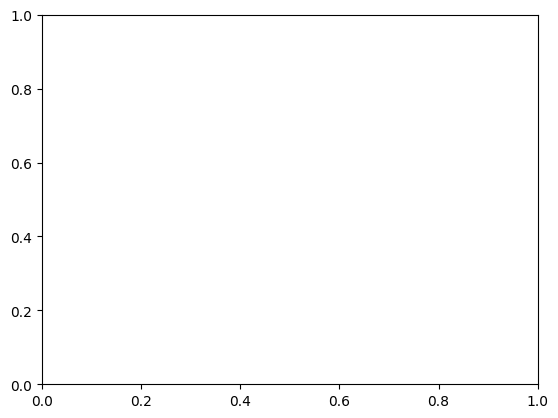

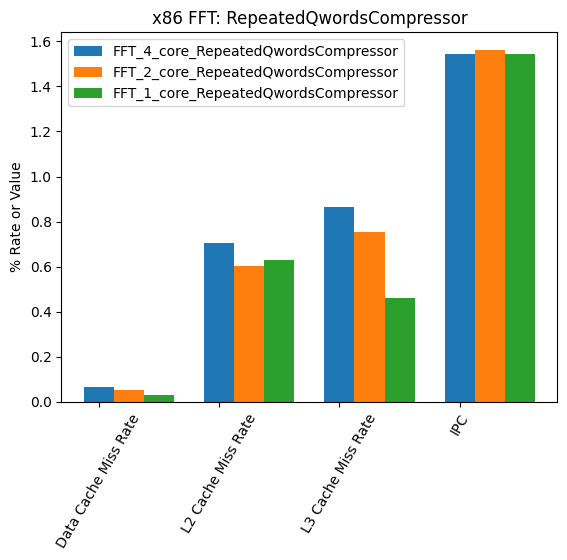

('FFT', '4_core', 'ZeroCompressor') [0.06711075, 0.7027604999999999, 0.862833, 1.5461945]
('FFT', '2_core', 'ZeroCompressor') [0.052064, 0.6041885, 0.754606, 1.5635815]
('FFT', '1_core', 'ZeroCompressor') [0.029289, 0.628338, 0.460246, 1.54521]


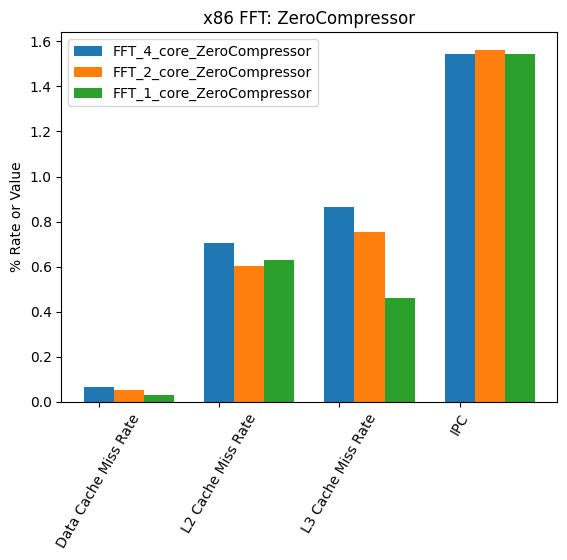

('FFT', '4_core', 'BDI') [0.06711275, 0.7027245, 0.863046, 1.54618375]
('FFT', '2_core', 'BDI') [0.0520645, 0.604177, 0.754585, 1.5636075]
('FFT', '1_core', 'BDI') [0.029289, 0.628338, 0.460246, 1.54521]


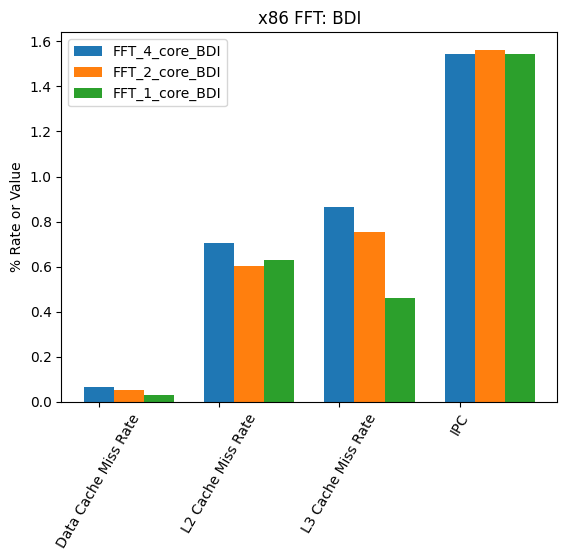

('FFT', '4_core', 'no_compression') [0.06711075, 0.7027604999999999, 0.862833, 1.5461945]
('FFT', '2_core', 'no_compression') [0.052064, 0.6041885, 0.754606, 1.5635815]
('FFT', '1_core', 'no_compression') [0.029289, 0.628338, 0.460246, 1.54521]


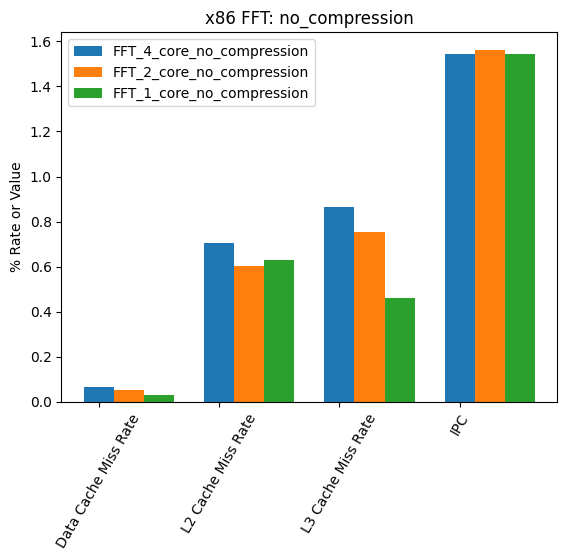

('LU', '4_core', 'BaseCacheCompressor') []
failed to plot:  BaseCacheCompressor
('LU', '4_core', 'BaseDictionaryCompressor') []
failed to plot:  BaseDictionaryCompressor
('LU', '4_core', 'Base64Delta8') [0.006310250000000001, 0.1679465, 0.775329, 1.3990940000000003]
('LU', '2_core', 'Base64Delta8') [0.0061875, 0.1129915, 0.752091, 1.3899815]
('LU', '1_core', 'Base64Delta8') [0.005861, 0.061667, 0.76071, 1.38876]


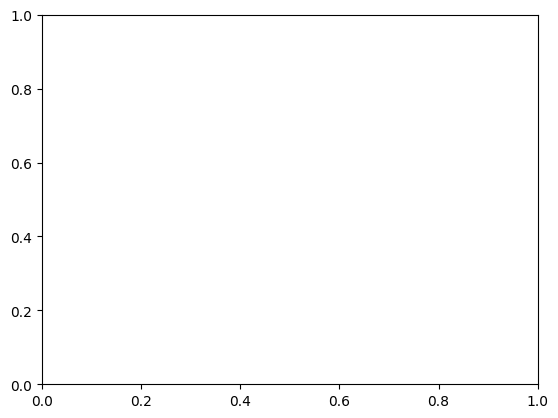

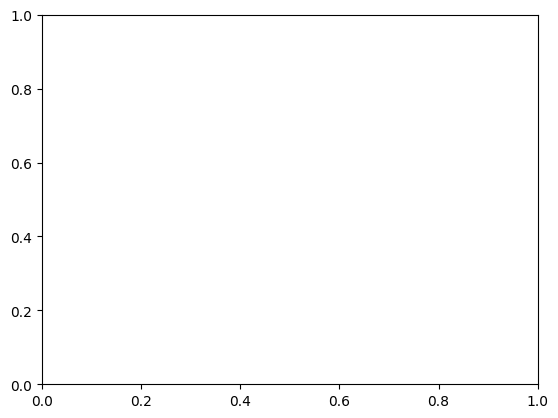

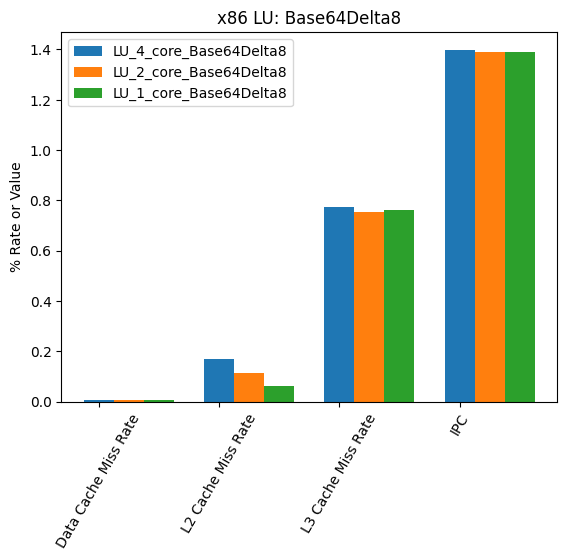

('LU', '4_core', 'Base64Delta16') [0.006310250000000001, 0.1679455, 0.775344, 1.3990940000000003]
('LU', '2_core', 'Base64Delta16') [0.0061875, 0.1129915, 0.752091, 1.3899815]
('LU', '1_core', 'Base64Delta16') [0.00586, 0.061646, 0.76095, 1.388761]


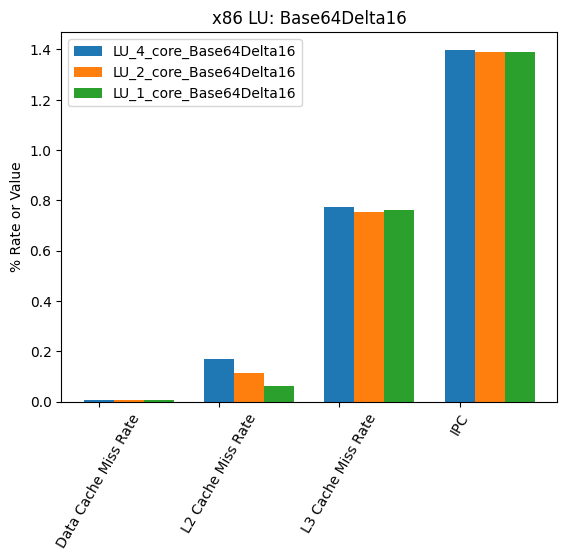

('LU', '4_core', 'Base64Delta32') [0.0063105, 0.16792225, 0.775338, 1.3991099999999999]
('LU', '2_core', 'Base64Delta32') [0.0061875, 0.1129915, 0.752091, 1.3899819999999998]
('LU', '1_core', 'Base64Delta32') [0.005861, 0.061667, 0.76071, 1.38876]


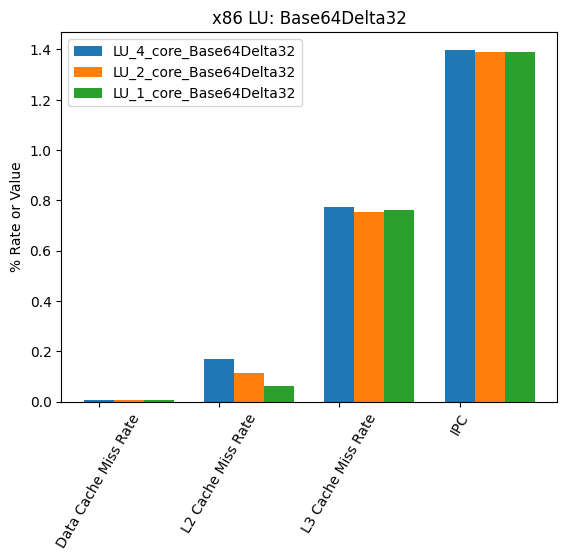

('LU', '4_core', 'Base32Delta8') [0.006311250000000001, 0.1680105, 0.775165, 1.39910625]
('LU', '2_core', 'Base32Delta8') [0.0061875, 0.1129915, 0.752091, 1.3899819999999998]
('LU', '1_core', 'Base32Delta8') [0.005861, 0.061667, 0.76071, 1.38876]


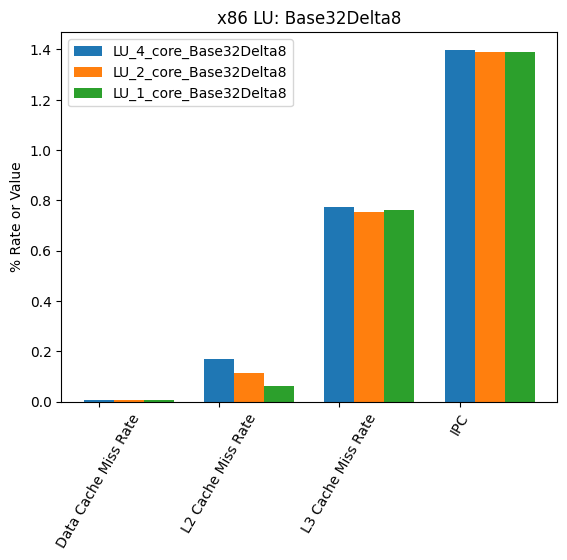

('LU', '4_core', 'Base32Delta16') [0.0063105, 0.16792225, 0.775338, 1.3991099999999999]
('LU', '2_core', 'Base32Delta16') [0.0061875, 0.1129915, 0.752091, 1.3899819999999998]
('LU', '1_core', 'Base32Delta16') [0.005861, 0.061667, 0.76071, 1.38876]


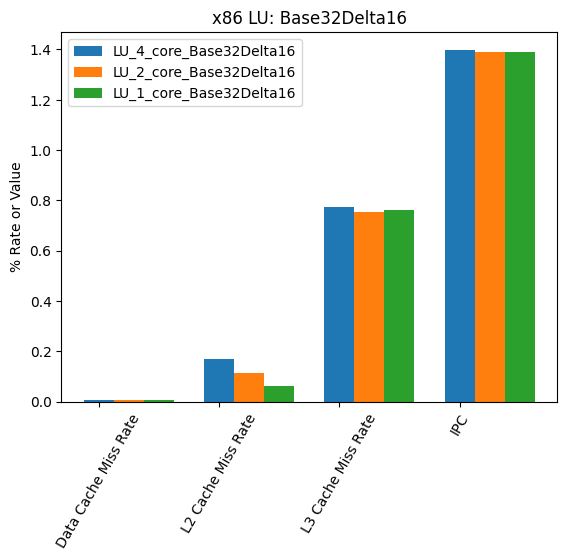

('LU', '4_core', 'Base16Delta8') [0.0063105, 0.16792225, 0.775338, 1.3991099999999999]
('LU', '2_core', 'Base16Delta8') [0.0061875, 0.1129915, 0.752091, 1.3899819999999998]
('LU', '1_core', 'Base16Delta8') [0.058577, 0.856004, 1.0, 0.609484]


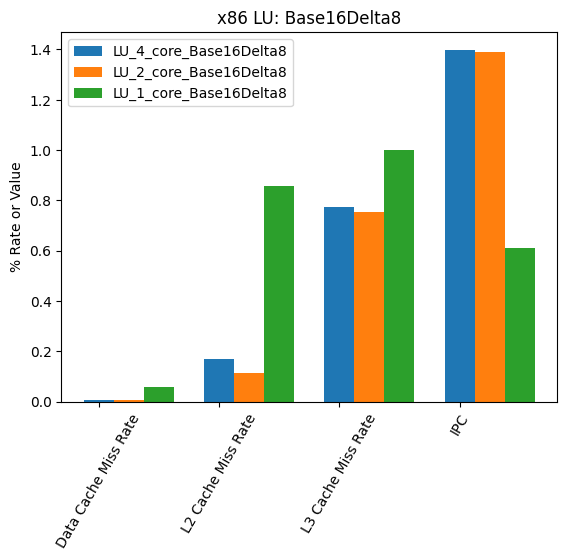

('LU', '4_core', 'CPack') [0.0063105, 0.16791850000000003, 0.775291, 1.39910525]
('LU', '2_core', 'CPack') [0.0061875, 0.1129915, 0.752155, 1.389977]
('LU', '1_core', 'CPack') [0.005861, 0.061668, 0.760694, 1.388754]


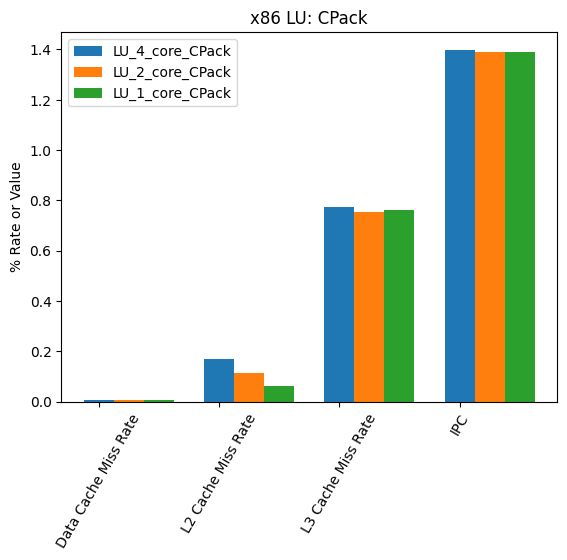

('LU', '4_core', 'FPC') [0.0063115, 0.168023, 0.774914, 1.3990799999999999]
('LU', '2_core', 'FPC') [0.0061875, 0.1129925, 0.752091, 1.389981]
('LU', '1_core', 'FPC') [0.005861, 0.061668, 0.760694, 1.38876]


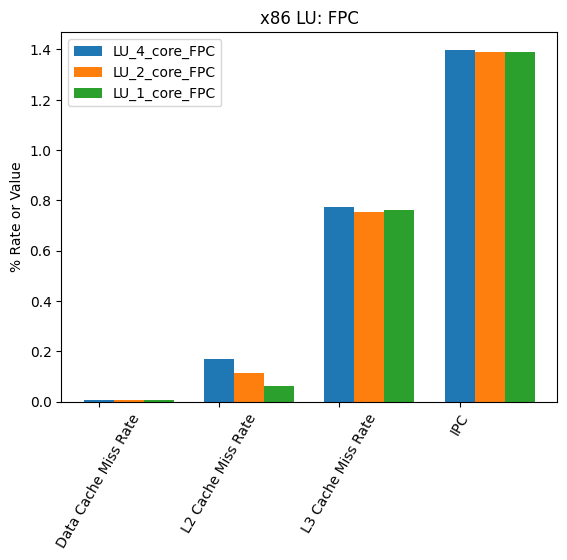

('LU', '4_core', 'FPCD') [0.006310250000000001, 0.167942, 0.775235, 1.399095]
('LU', '2_core', 'FPCD') [0.0061875, 0.1129925, 0.752061, 1.3899845]
('LU', '1_core', 'FPCD') [0.005861, 0.061668, 0.760694, 1.388761]


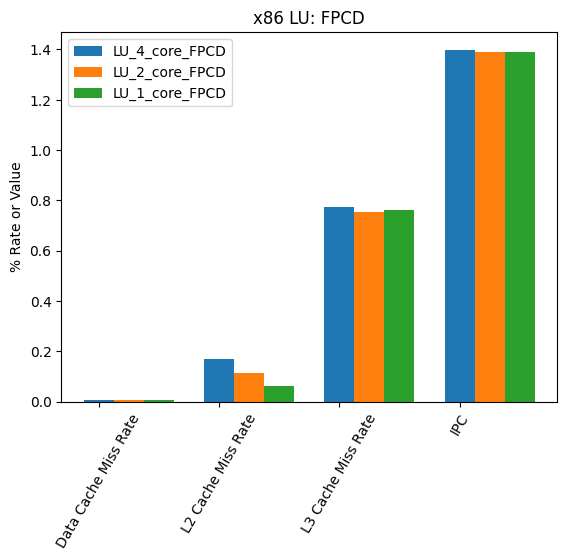

('LU', '4_core', 'FrequentValuesCompressor') [0.006311499999999999, 0.1679885, 0.775322, 1.3991075]
('LU', '2_core', 'FrequentValuesCompressor') [0.0061875, 0.112995, 0.752101, 1.3899759999999999]
('LU', '1_core', 'FrequentValuesCompressor') [0.005861, 0.061648, 0.760919, 1.388761]


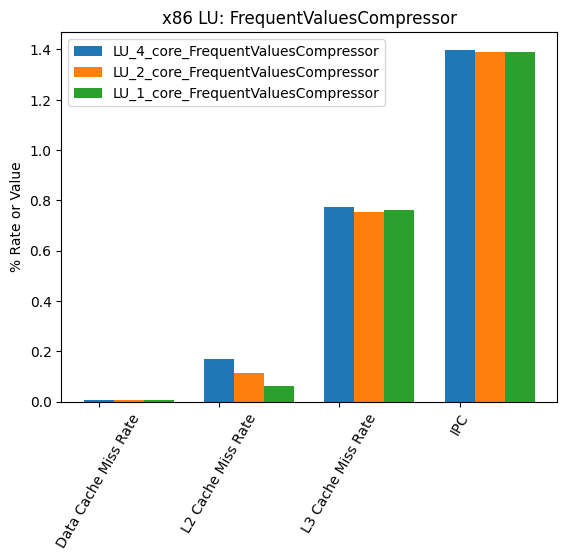

('LU', '4_core', 'MultiCompressor') [0.006311499999999999, 0.16799199999999997, 0.775347, 1.3991034999999998]
('LU', '2_core', 'MultiCompressor') [0.0061875, 0.1129925, 0.75214, 1.389977]
('LU', '1_core', 'MultiCompressor') [0.005861, 0.061668, 0.760694, 1.38876]


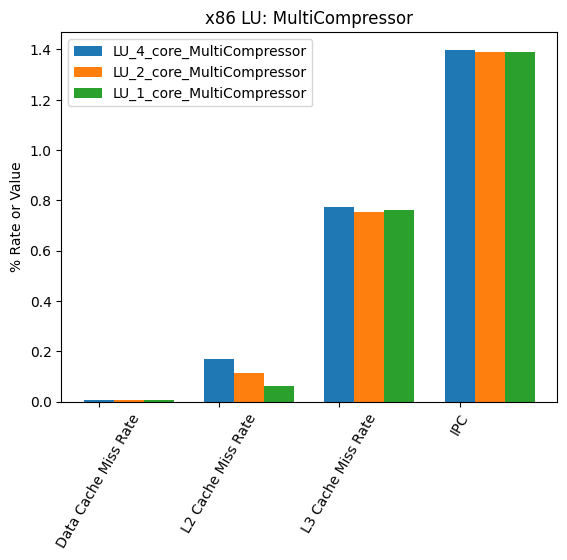

('LU', '4_core', 'PerfectCompressor') []
failed to plot:  PerfectCompressor
('LU', '4_core', 'RepeatedQwordsCompressor') [0.006310250000000001, 0.16794175, 0.775297, 1.3990945]
('LU', '2_core', 'RepeatedQwordsCompressor') [0.0061875, 0.1129915, 0.752091, 1.3899819999999998]
('LU', '1_core', 'RepeatedQwordsCompressor') [0.005861, 0.061667, 0.76071, 1.38876]


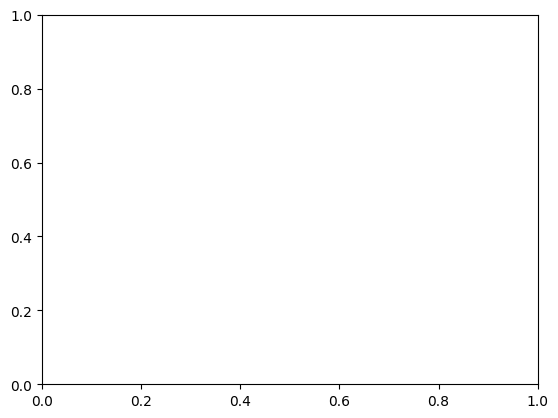

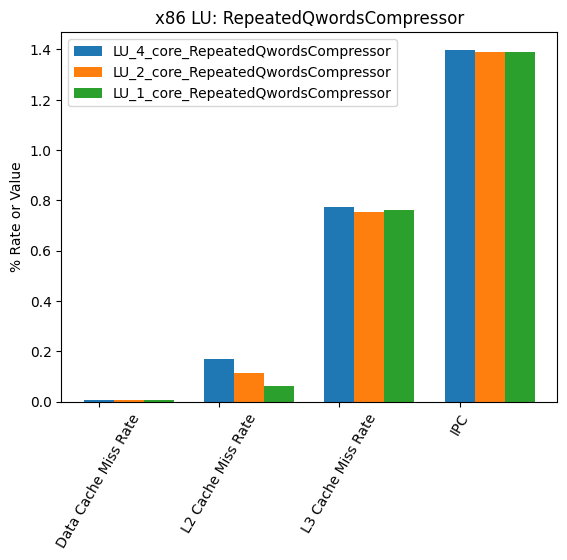

('LU', '4_core', 'ZeroCompressor') [0.006310250000000001, 0.16794175, 0.775297, 1.3990945]
('LU', '2_core', 'ZeroCompressor') [0.0061875, 0.1129915, 0.752091, 1.3899819999999998]
('LU', '1_core', 'ZeroCompressor') [0.005861, 0.061667, 0.76071, 1.38876]


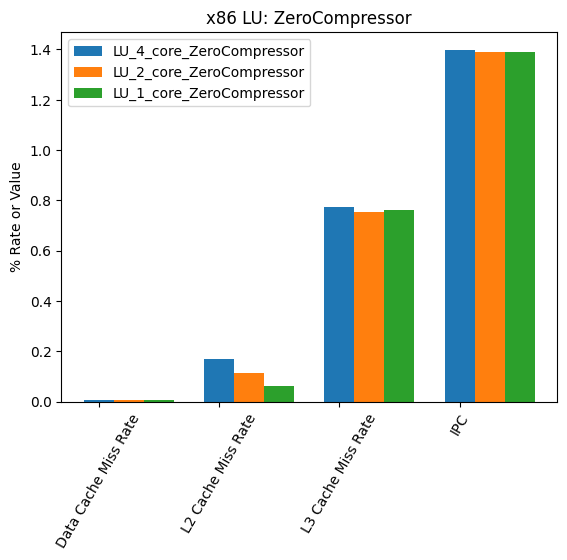

('LU', '4_core', 'BDI') [0.006311000000000001, 0.16799275000000002, 0.775432, 1.39910775]
('LU', '2_core', 'BDI') [0.0061875, 0.1129915, 0.752091, 1.3899815]
('LU', '1_core', 'BDI') [0.00586, 0.061646, 0.76095, 1.388761]


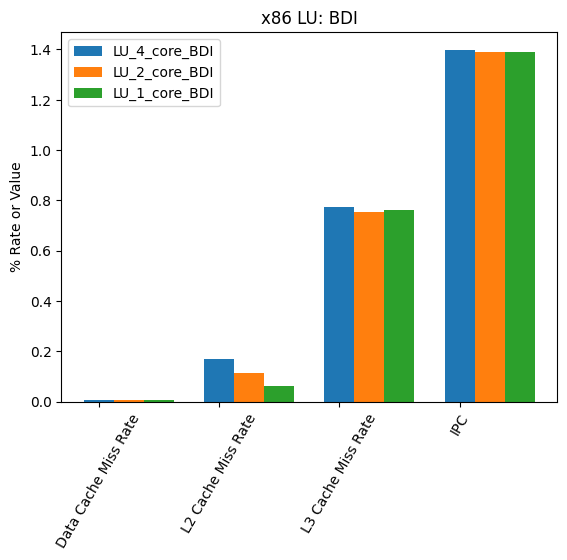

('LU', '4_core', 'no_compression') [0.0063105, 0.16792225, 0.775338, 1.3991099999999999]
('LU', '2_core', 'no_compression') [0.0061875, 0.1129915, 0.752091, 1.3899819999999998]
('LU', '1_core', 'no_compression') [0.005861, 0.061667, 0.76071, 1.38876]


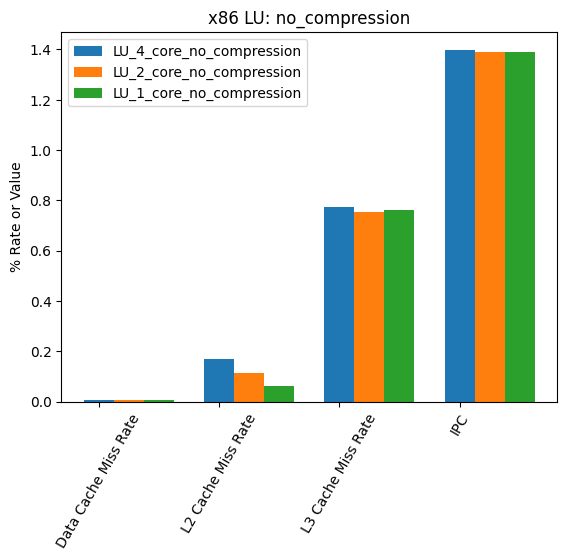

('RADIX', '4_core', 'BaseCacheCompressor') []
failed to plot:  BaseCacheCompressor
('RADIX', '4_core', 'BaseDictionaryCompressor') []
failed to plot:  BaseDictionaryCompressor
('RADIX', '4_core', 'Base64Delta8') []
failed to plot:  Base64Delta8
('RADIX', '4_core', 'Base64Delta16') []
failed to plot:  Base64Delta16
('RADIX', '4_core', 'Base64Delta32') []
failed to plot:  Base64Delta32
('RADIX', '4_core', 'Base32Delta8') []
failed to plot:  Base32Delta8
('RADIX', '4_core', 'Base32Delta16') []
failed to plot:  Base32Delta16
('RADIX', '4_core', 'Base16Delta8') []
failed to plot:  Base16Delta8
('RADIX', '4_core', 'CPack') []
failed to plot:  CPack
('RADIX', '4_core', 'FPC') []
failed to plot:  FPC
('RADIX', '4_core', 'FPCD') []
failed to plot:  FPCD
('RADIX', '4_core', 'FrequentValuesCompressor') []
failed to plot:  FrequentValuesCompressor
('RADIX', '4_core', 'MultiCompressor') []
failed to plot:  MultiCompressor
('RADIX', '4_core', 'PerfectCompressor') []
failed to plot:  PerfectCompresso

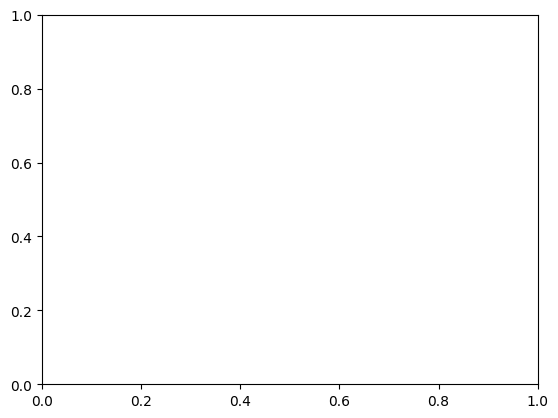

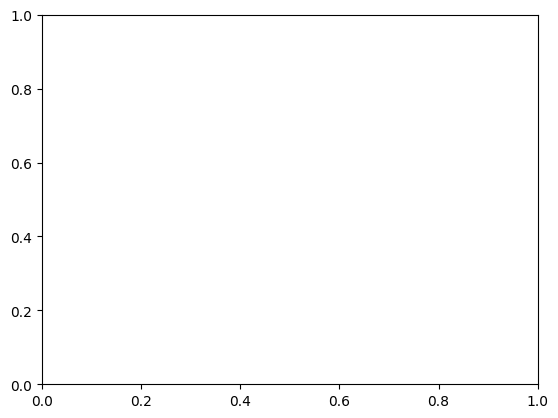

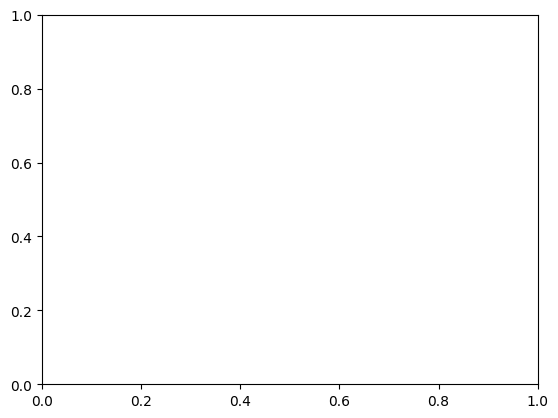

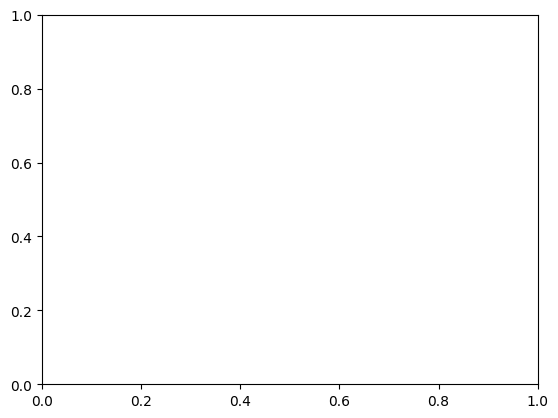

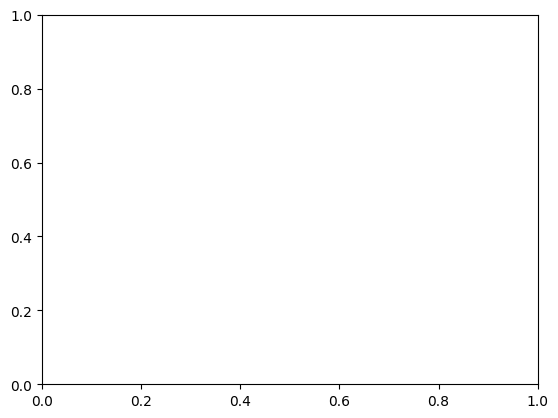

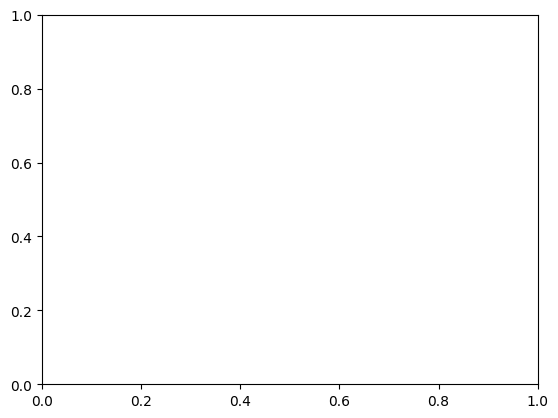

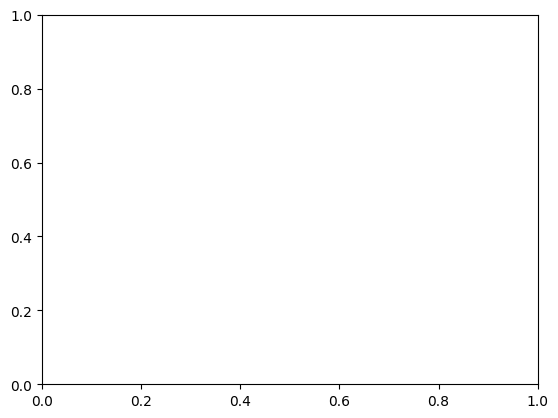

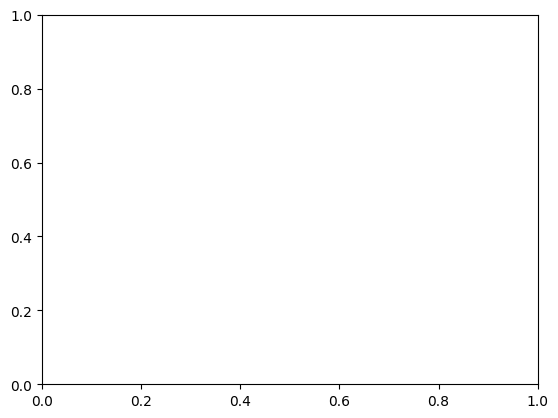

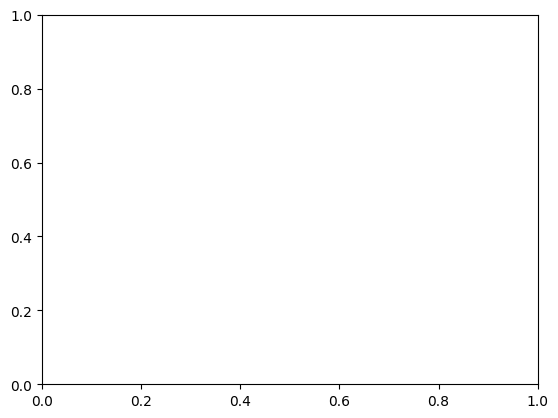

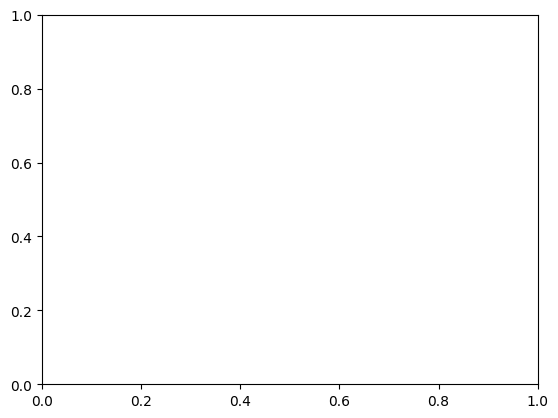

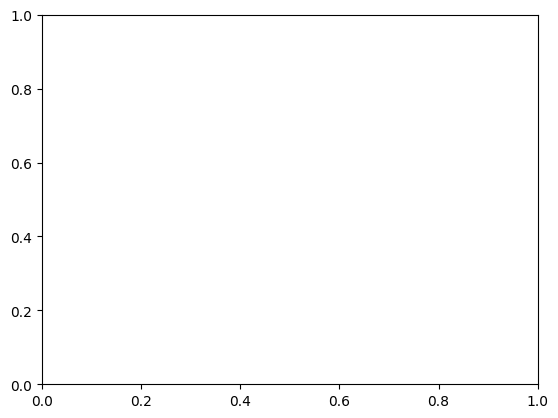

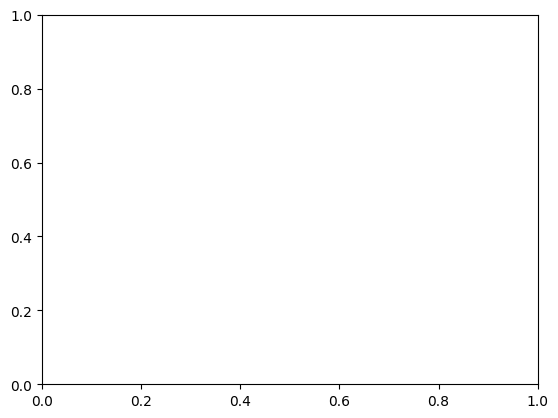

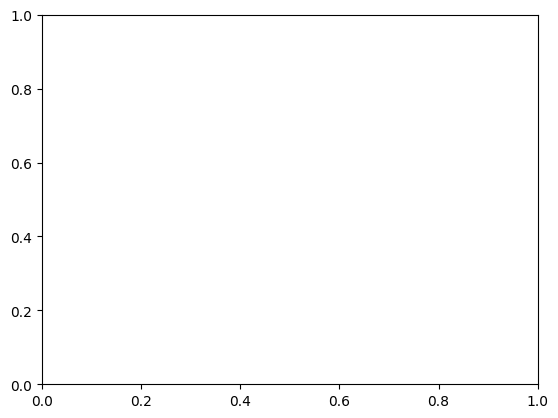

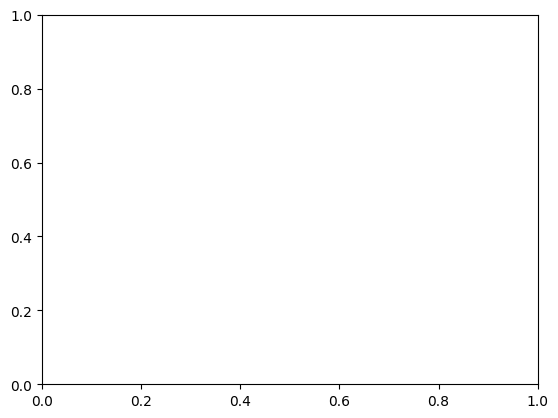

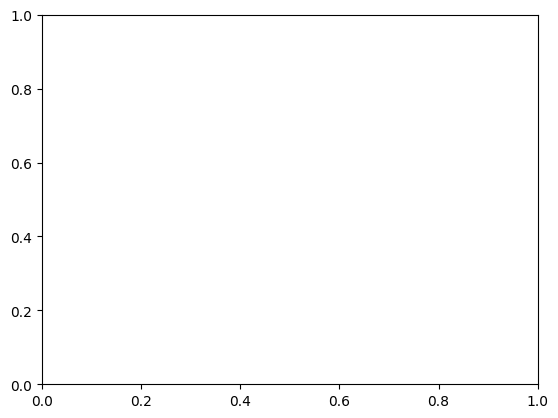

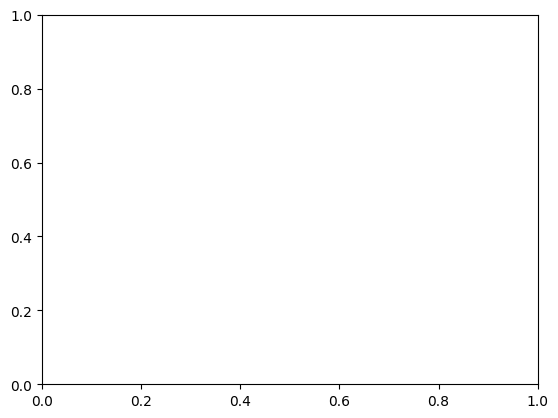

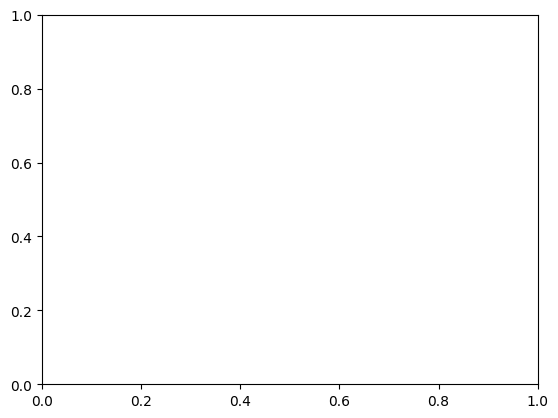

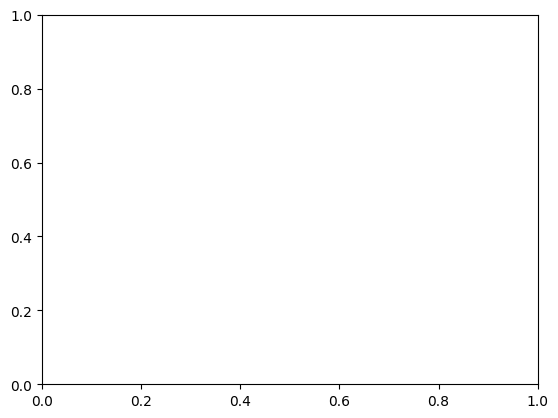

In [26]:
for p in progs:
    for compressor in all_compressors:
        try:
            plot_benchmark(compressor, p, x86_wanted_metrics, "x86")
        except:
            print("failed to plot: ", compressor)